* **Mohammed JAWHAR**
* **Mohamad EL OSMAN**

Welcome to the Stock Market Prediction Project, where we explore and implement predictive modeling for stock market data across five major industries in five different countries. The project employs two distinct approaches to forecasting: a real-time strategy using river models and a batch approach leveraging LSTM, ARIMA and Meta Prophet model.

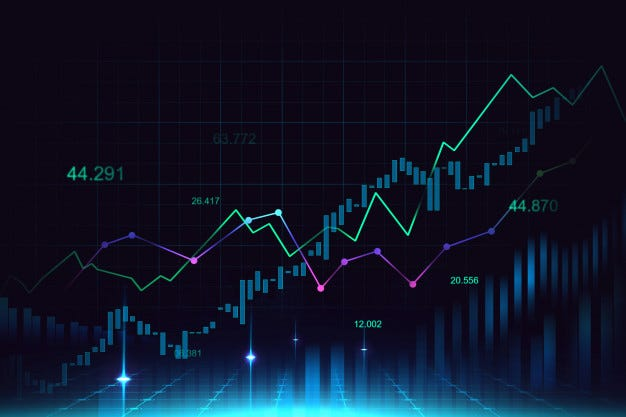

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import requests
import yfinance as yf
import river 
import kafka
from kafka import KafkaProducer
from kafka import KafkaConsumer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import time
from time import perf_counter
from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Embedding, Dropout, Input, LSTM, Reshape, Lambda
import tensorflow.keras.layers as layers

import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA


import warnings
warnings.filterwarnings('ignore')

We start first by importing the necessary Data. In our case, we have selected five prominent companies from diverse industries, each located in a different country:

* ***Google:*** Google is a multinational technology company that specializes in internet-related services and products. Its primary focus is on search engines, online advertising technologies, cloud computing, software, and hardware.  
  
  **Key Products/Services:** Google Search, Google Ads, Google Cloud Platform, Android OS, YouTube, Google Maps, and various other online services and products.  
  
  
* ***BNP PARIBAS:*** BNP Paribas is a French multinational banking and financial services company with a global presence. It is one of the largest banks in the world and offers a wide range of services, including retail banking, corporate and institutional banking, investment banking, asset management, and insurance.
  
  **Key Services:** Retail banking, corporate banking, investment banking, asset management, insurance, and other financial services.


* ***Alibaba Group:*** Alibaba Group is a Chinese multinational conglomerate specializing in e-commerce, retail, internet, and technology. It was founded by Jack Ma in 1999 and has since become a dominant force in the global e-commerce market. Alibaba operates various online marketplaces, cloud computing services, and digital media platforms.
  
  **Key Platforms:** Alibaba.com (B2B e-commerce), Taobao (C2C and B2C e-commerce), Tmall (B2C e-commerce), AliExpress (online retail), and Alibaba Cloud (cloud computing services).

* ***Rosneft:*** Rosneft is a Russian global energy company specializing in the exploration, production, transportation, and marketing of natural gas and other hydrocarbons. It holds a significant position in the global energy market, particularly in the Russian Federation.
  
  **Key Activities:** Exploration and production of natural gas, transportation of gas through pipelines, and marketing and sale of gas and other energy products.

* ***Shell:*** Royal Dutch Shell, commonly known as Shell, is a British-Dutch multinational oil and gas company. Shell is one of the largest and most diversified energy companies globally, involved in various aspects of the energy industry, including exploration, production, refining, distribution, and marketing of oil and gas products.
  
  **Key Activities:** Exploration and production of oil and gas, refining and marketing of petroleum products, production of petrochemicals, and involvement in renewable energy projects.

## IMPORTING DATA

In [2]:
tickers = ['GOOG', 'BNPQY', 'BABA', 'ROSN.ME', 'SHEL']
companies = ["Google", "BNPParibas", "Alibaba", "ROSNEFT", "SHELL"]

def import_data(company_name, ticker_name, file_name, starting_date, ending_date, interval, short_roll, long_roll):
    """
    Imports financial data, displays basic company information, calculates rolling averages,
    and saves the processed data as a pickle file.

    Parameters
    ----------
    company_name : str
        The name of the company.
    ticker_name : str
        The stock ticker symbol.
    file_name : str
        The base name for the pickle file.
    starting_date : str
        The start date for downloading historical data (format: 'YYYY-MM-DD').
    ending_date : str
        The end date for downloading historical data (format: 'YYYY-MM-DD').
    interval : str
        The time interval for data (e.g., '1d' for daily).
    short_roll : int
        The window size for short-term rolling average.
    long_roll : int
        The window size for long-term rolling average.
    
    Returns
    -------
    None
    """
    # Create a yfinance Ticker object for the specified stock
    tick = yf.Ticker(ticker_name)
    
    # Display basic information about the company
    print("**********" + company_name + "**********" )
    for x in ['country', 'industry', 'currentPrice', 'targetMeanPrice']:
        try:
            print(x, ":", tick.info[x])
        except:
            print(x, ":")
    
    # Download historical stock data for the specified time period and interval
    data = yf.download(ticker_name, start=starting_date, end=ending_date, interval=interval)
    
    # Calculate short-term rolling average and long-term rolling average
    data['short_rolling'] = data['Close'].rolling(window=short_roll).mean()
    data['long_rolling'] = data['Close'].rolling(window=long_roll).mean()
    
    # Save the processed data as a pickle file
    data.to_pickle(str(file_name) + "_" + str(interval) + ".pkl")

    

In [3]:
short_roll = 7
long_roll = 30
interval = "1d"
freq = 'd'
start_date = '2018-01-01'
end_date = '2023-12-31'
for i in range(len(tickers)):
    import_data(companies[i], tickers[i], companies[i], start_date, end_date, interval, short_roll, long_roll)

**********Google**********
country : United States
industry : Internet Content & Information
currentPrice : 137.39
targetMeanPrice : 146.1
[*********************100%%**********************]  1 of 1 completed
**********BNPParibas**********
country : France
industry : Banks - Regional
currentPrice : 34.56
targetMeanPrice : 47.21
[*********************100%%**********************]  1 of 1 completed
**********Alibaba**********
country : China
industry : Internet Retail
currentPrice : 73.01
targetMeanPrice : 125.65
[*********************100%%**********************]  1 of 1 completed
**********ROSNEFT**********
country : Russia
industry : Oil & Gas Integrated
currentPrice : 351.2
targetMeanPrice :
[*********************100%%**********************]  1 of 1 completed
**********SHELL**********
country : United Kingdom
industry : Oil & Gas Integrated
currentPrice : 65.73
targetMeanPrice : 74.04
[*********************100%%**********************]  1 of 1 completed


Each Company's stock market dataset looks like the following :

In [4]:
df = pd.read_pickle("Google_1d.pkl")
df.head()

Open       High        Low      Close  Adj Close    Volume  \
Date                                                                          
2018-01-02  52.417000  53.347000  52.261501  53.250000  53.250000  24752000   
2018-01-03  53.215500  54.314499  53.160500  54.124001  54.124001  28604000   
2018-01-04  54.400002  54.678501  54.200100  54.320000  54.320000  20092000   
2018-01-05  54.700001  55.212502  54.599998  55.111500  55.111500  25582000   
2018-01-08  55.111500  55.563499  55.081001  55.347000  55.347000  20952000   

            short_rolling  long_rolling  
Date                                     
2018-01-02            NaN           NaN  
2018-01-03            NaN           NaN  
2018-01-04            NaN           NaN  
2018-01-05            NaN           NaN  
2018-01-08            NaN           NaN

It is worth noting that we are particularly interestesd in the ***Close*** column, as it represents the closing price - the last recorded price at the end of the trading session - of a stock for a particular trading day, and it is the one that is often used by traders and analysts to assess trends, calculate returns, and make informed investment decisions.

## Exploration

Now, let's proceed to visually represent the stock data for each company, recognizing it as a financial time series. We aim to observe trends over the chosen timeframe. As a matter of clarification, we have employed a rolling technique on our stocks. This process serves to smooth and denoise the data, making trends more discernible while mitigating the impact of volatility.

In [5]:
def plot_close_price(file_name, short_roll, long_roll, freq):
    """
    Plots the closing price along with short-term and long-term moving averages.

    Parameters
    ----------
    file_name : str
        The name of the pickle file containing financial data.
    short_roll : int
        The window size for short-term rolling average.
    long_roll : int
        The window size for long-term rolling average.
    freq : str
        The frequency of the data (e.g., '1d' for daily).

    Returns
    -------
    None
    """
    plt.figure(figsize=(18, 6))
    plt.grid()

    # Read data from the pickle file
    df = pd.read_pickle(file_name)

    # Plot closing price
    plt.plot(df['Close'], label='Closing price')

    # Plot short-term rolling average
    plt.plot(df['short_rolling'], label=" ".join([str(short_roll), freq, 'moving average']))

    # Plot long-term rolling average
    #plt.plot(df['long_rolling'], label=" ".join([str(long_roll), freq, 'moving average']))

    # Set plot title, labels, and legend
    plt.title("Closing price for " + file_name[:-7] + " stock")
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend(loc='upper left')

    # Show the plot
    plt.show()

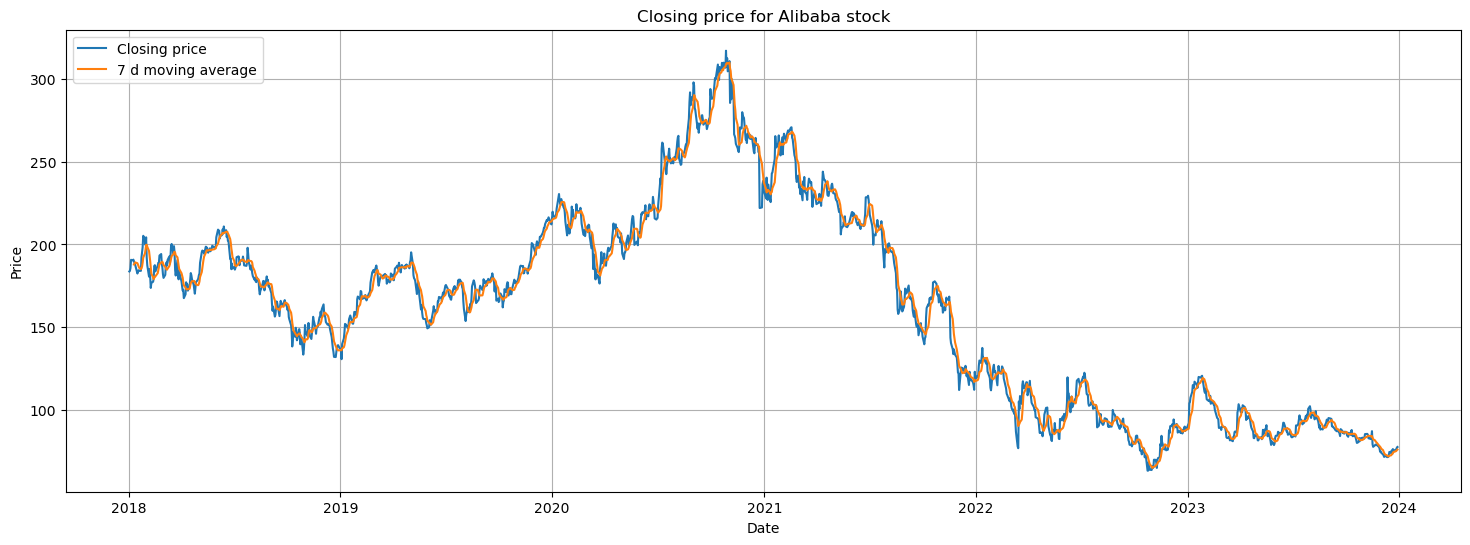

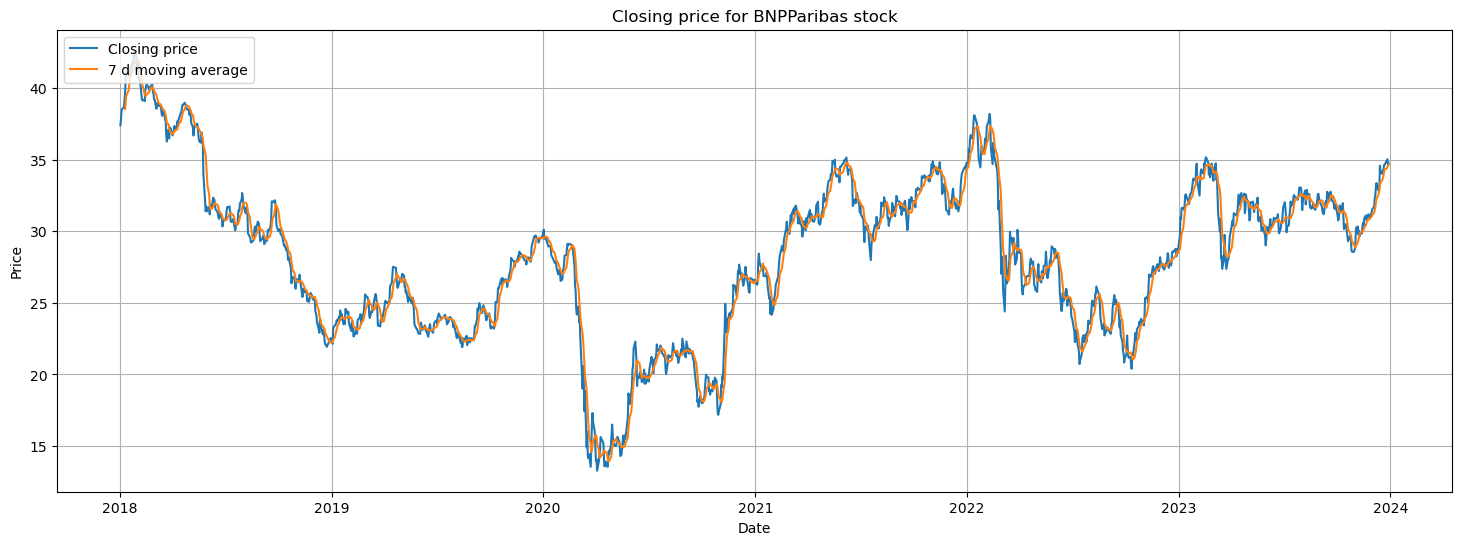

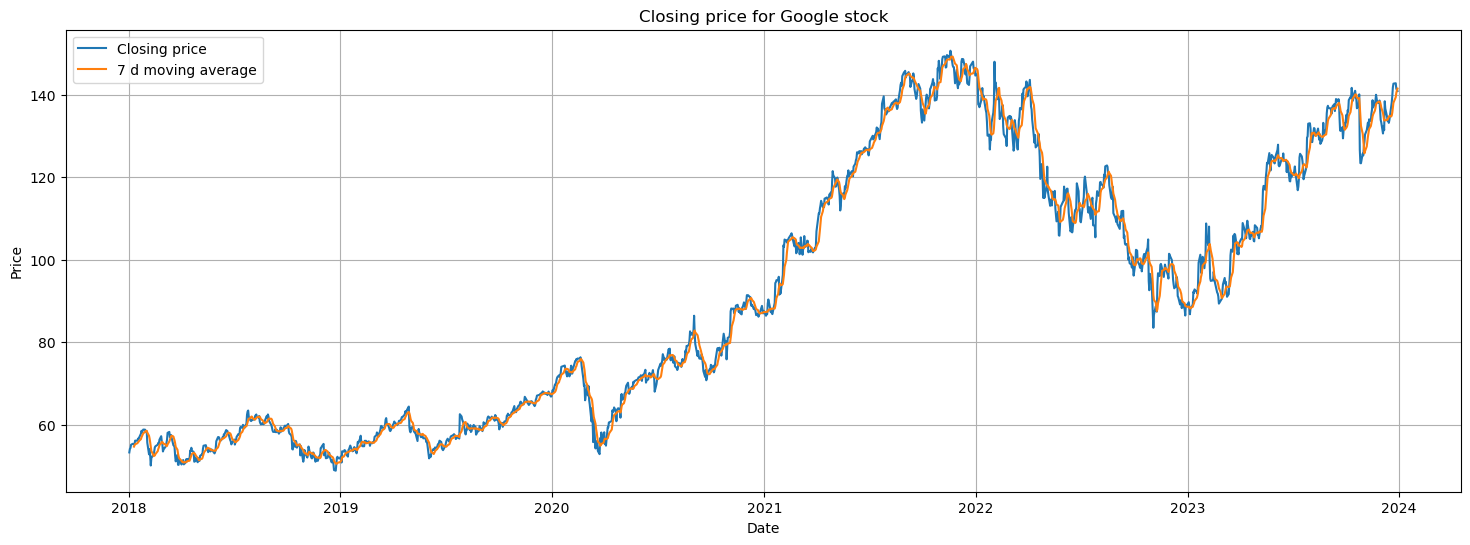

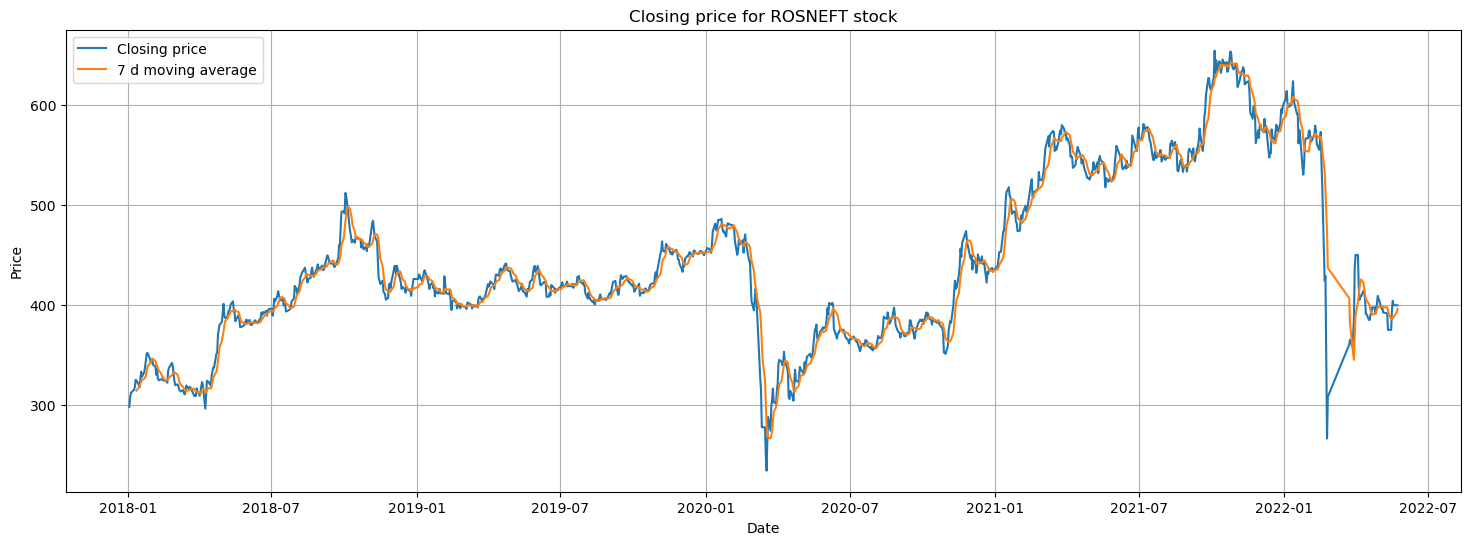

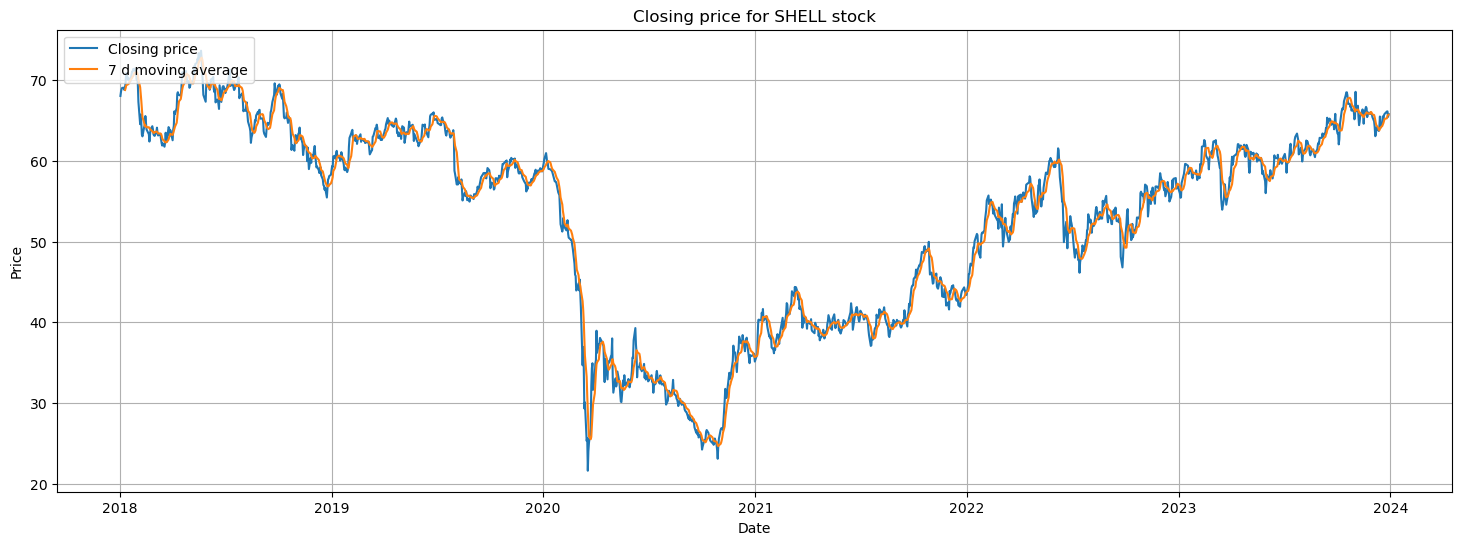

In [6]:
pkl_files = glob.glob("*.pkl")
for file in pkl_files:
    plot_close_price(file, short_roll, long_roll, freq)

In [7]:
for file in pkl_files:
    df = pd.read_pickle(file)
    print("**************************")
    print("Company: ", file[:-7])
    print("Nan values: ", df['Close'].isna().sum())
    print("Number of instances: ", len(df['Close']))
    print("Minimum value:", round(df['Close'].min(),2))
    print("Maximum value:", round(df['Close'].max(),2))

**************************
Company:  Alibaba
Nan values:  0
Number of instances:  1509
Minimum value: 63.15
Maximum value: 317.14
**************************
Company:  BNPParibas
Nan values:  0
Number of instances:  1509
Minimum value: 13.28
Maximum value: 42.61
**************************
Company:  Google
Nan values:  0
Number of instances:  1509
Minimum value: 48.81
Maximum value: 150.71
**************************
Company:  ROSNEFT
Nan values:  0
Number of instances:  1084
Minimum value: 234.0
Maximum value: 654.3
**************************
Company:  SHELL
Nan values:  0
Number of instances:  1509
Minimum value: 21.62
Maximum value: 73.64


## Batch Modeling

### 1- LSTM

Without further ado, we will try to implement first an LSTM model that does the prediction. we tried to subdivise the preprocessing tasks and include them directly in the modeling function for the purpose of clarity.


This LSTM model operates by training on historical data, utilizing a sequence of prices spanning sequence_length days to forecast the next day's stock market value. Following the training phase, predictions on the test set are made in a sequential manner. The model begins with the last sequence from the training data, predicting the subsequent day's value and updating the input sequence iteratively This update involves adding the predicted value to the end of the sequence and removing the first one, thus, maintaining the same sequence length and moving forward by one day. This process continues for the entire test set, generating a sequence of predicted values. To evaluate performance, these predictions are inverse-transformed from the scaled domain, allowing comparison with actual values. The model's performance is assessed using metrics such as Mean Absolute Error (MAE), Mean Absolute Percentage Error (MAPE), and Root Mean Squared Error (RMSE). A visual representation of the predicted and actual stock prices for both training and testing datasets at the end provides insights into the model's effectiveness.

In [8]:
def calculate_metrics(actual, forecast):
    """
    Calculate Mean Absolute Error (MAE), Mean Absolute Percentage Error (MAPE), and Root Mean Squared Error (RMSE).

    Parameters:
    - actual (array-like): Array of actual values.
    - forecast (array-like): Array of predicted/forecasted values.

    Returns:
    - tuple: MAE, MAPE, and RMSE values.
    """
    mae = mean_absolute_error(actual, forecast)
    mape = np.mean(np.abs((actual - forecast) / actual)) * 100
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    return mae, mape, rmse


def plot_actual_pred(df, train_pred, test_pred, company_name):
    """
    Plot actual vs predicted stock market prices for both training and testing datasets.

    Parameters:
    - df (DataFrame): DataFrame containing stock market data.
    - train_pred (array-like): Predicted values for the training dataset.
    - test_pred (array-like): Predicted values for the testing dataset.
    - company_name (str): Name of the company for plot title.
    """
    plt.figure(figsize=(18, 6))
    plt.grid()

    train_index = range(sequence_length, sequence_length + len(train_pred))
    test_index = range(sequence_length + len(train_pred), sequence_length + len(train_pred) + len(test_pred))

    plt.plot(df.index[train_index], df['Close'][train_index], label='Actual Train Data')
    plt.plot(df.index[test_index], df['Close'][test_index], label='Actual Test Data')

    plt.plot(df.index[train_index], train_pred, label='Predicted Train Data')
    plt.plot(df.index[test_index], test_pred, label='Predicted Test Data')

    plt.title("Actual vs predicted {} stock market prices - LSTM".format(company_name))
    plt.xlabel("Date")
    plt.ylabel("Stock market price")
    plt.legend()
    plt.show()

    
def create_sequences(data, seq_length):
    """
    Create input sequences and corresponding labels for LSTM model.

    Parameters:
    - data (array-like): Time series data.
    - seq_length (int): Length of each input sequence.

    Returns:
    - tuple: Input sequences (X) and corresponding labels (y).
    """
    X, y = [], []
    n = len(data)
    for i in range(n - seq_length):
        seq = data[i: i + seq_length]
        label = data[i + seq_length]
        X.append(seq)
        y.append(label)
    return np.array(X), np.array(y)



# Set random seeds for reproducibility
seed_value = 1
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

def build_lstm(file_name, sequence_length, split_ratio, N_neurons=100, dropout=0.1, epochs=50, loss='mape', verbose=True):
    """
    Build and train an LSTM model for stock market price prediction.

    Parameters:
    - file_name (str): Name of the file containing stock market data.
    - sequence_length (int): Length of input sequences for the LSTM model.
    - split_ratio (float): Ratio to split the data into training and testing sets.
    - N_neurons (int): Number of neurons in the LSTM layer.
    - dropout (float): Dropout rate in the LSTM layer.
    - epochs (int): Number of training epochs.
    - loss (str): Loss function for model compilation.
    - verbose (bool): Whether to print training information and plot results.

    Returns:
    - list: Metrics including MAE, MAPE, RMSE, and training time.
    """
    start_time = time.time()
    
    df = pd.read_pickle(file_name)
    
    # Extract 'Close' column for training
    data = df[['Close']].values
    split_index = int(split_ratio * len(data))
    train_data, test_data = data[:split_index], data[split_index:]

    # Standardize the data
    scaler = StandardScaler()
    train_data_scaled = scaler.fit_transform(train_data)
    test_data_scaled = scaler.transform(test_data)

    # Function to create sequences for LSTM
    # Create sequences
    X_train, y_train = create_sequences(train_data_scaled, sequence_length)
    X_test, y_test = create_sequences(test_data_scaled, sequence_length)
    
    # Build LSTM model
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    tf.config.experimental.enable_op_determinism()
    
    model = Sequential()
    model.add(LSTM(units=N_neurons, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss=loss)
    
    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    
    training_time = time.time() - start_time
    
    # Make predictions on the test set while adding each prediction to the input sequence
    test_predictions = []
    test_seq = np.array([X_train[-1]])
    for i in range(len(X_test)):
        #Make the prediction
        prediction = model.predict(test_seq, verbose=0)
        test_predictions.append(prediction[0])
        #Add the predicted value to the input sequence for the next iteration
        test_seq = np.concatenate([test_seq[:, 1:], np.array([[prediction[0]]])], axis=1)
    
    # Inverse transform predictions to original scale
    train_predictions = scaler.inverse_transform(model.predict(X_train).reshape(-1, 1))
    test_predictions = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))
    
    mae_test, mape_test, rmse_test = calculate_metrics(df['Close'][-len(y_test):].values.flatten(), test_predictions.flatten())
    
    if verbose:
        # Plot the results
        plot_actual_pred(df, train_predictions, test_predictions, file_name[:-7])
    
    # Return metrics as a list
    return [mae_test, mape_test, rmse_test, training_time]


In [9]:
# Define sequence length
sequence_length = 60  
# Split the data into training and testing sets
split_ratio = 0.8




36/36 [==============================] - 1s 15ms/step


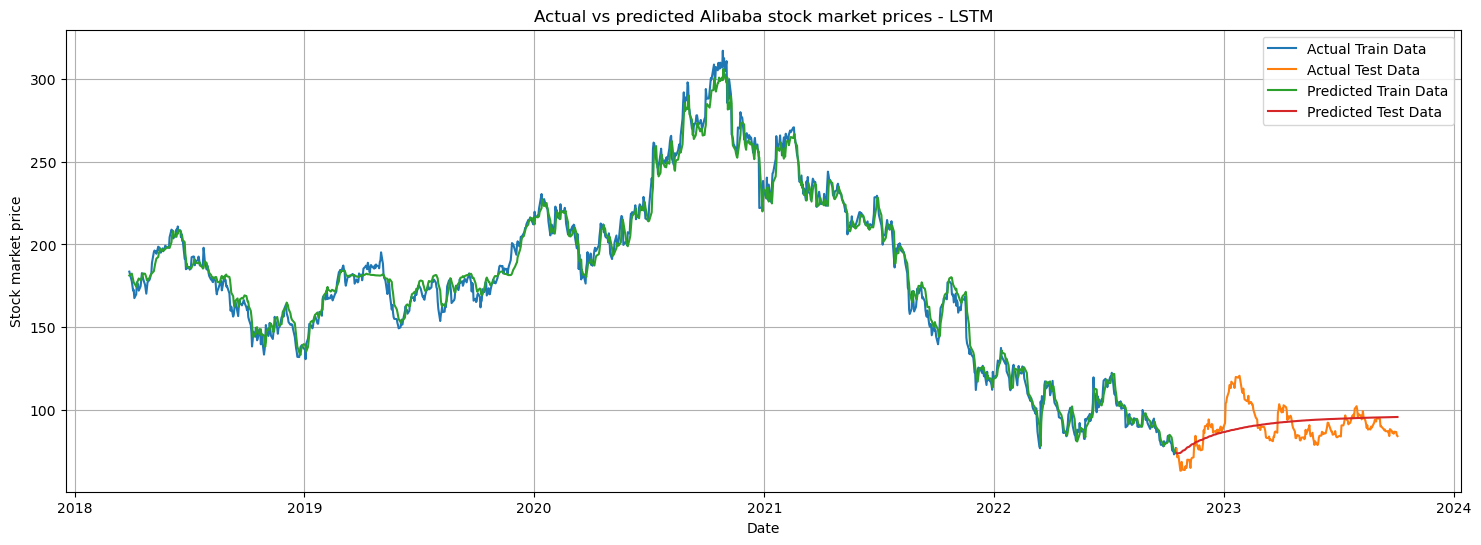

36/36 [==============================] - 1s 17ms/step


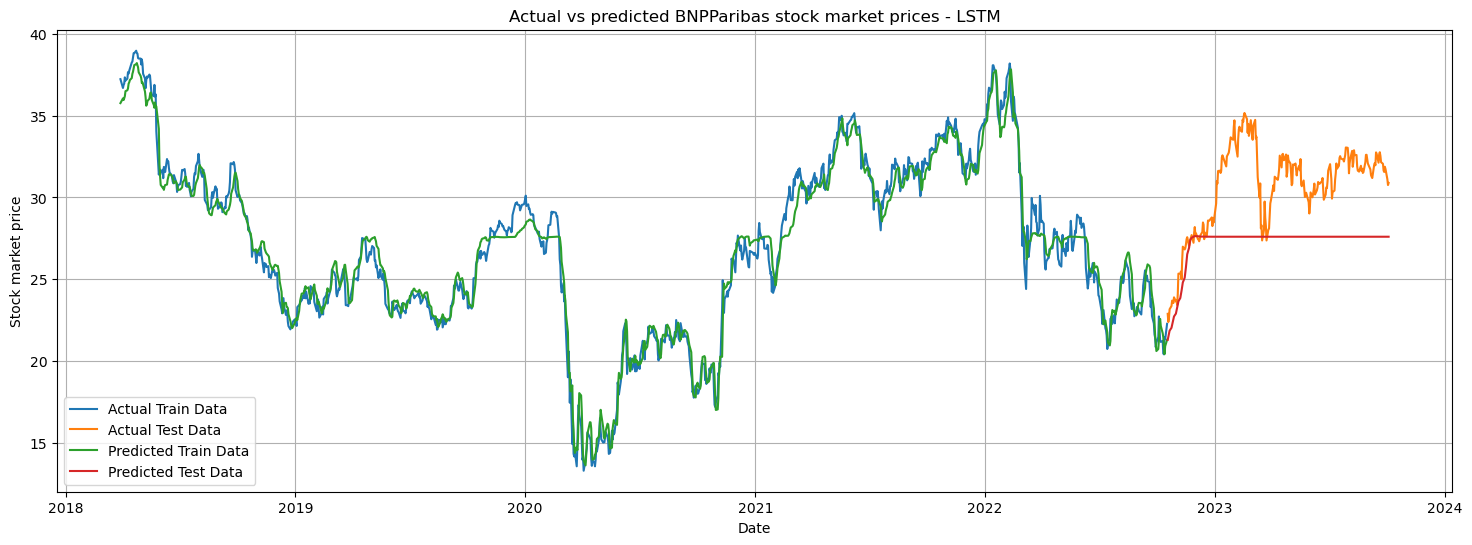

36/36 [==============================] - 0s 11ms/step


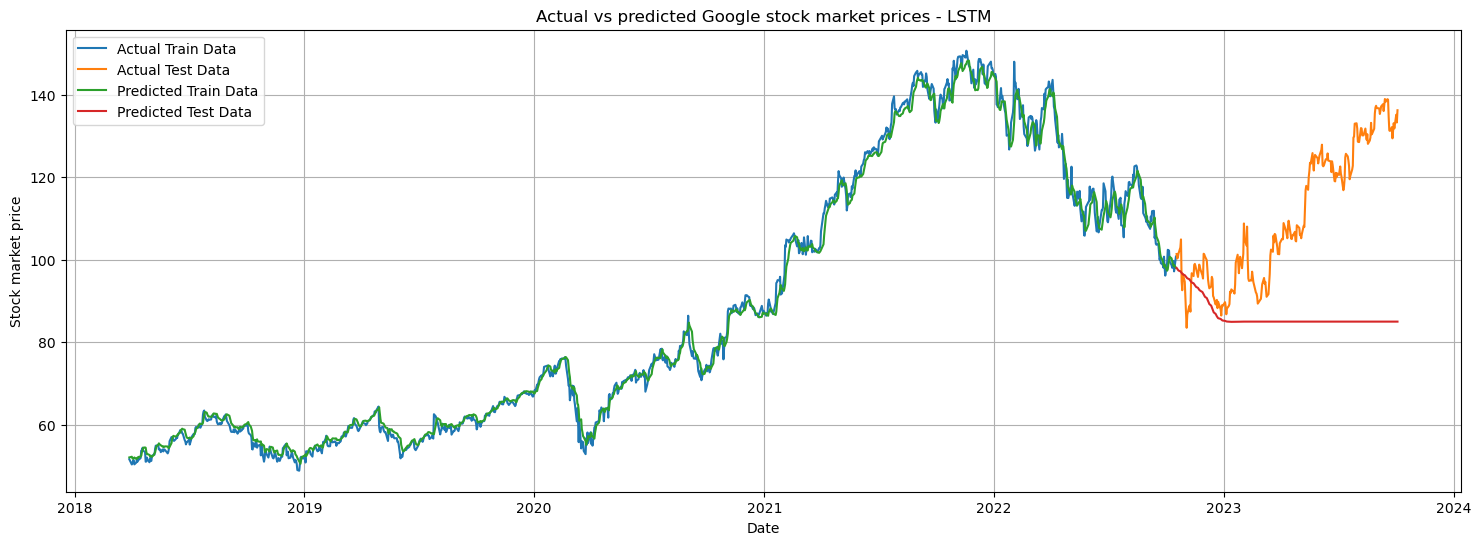

26/26 [==============================] - 0s 12ms/step


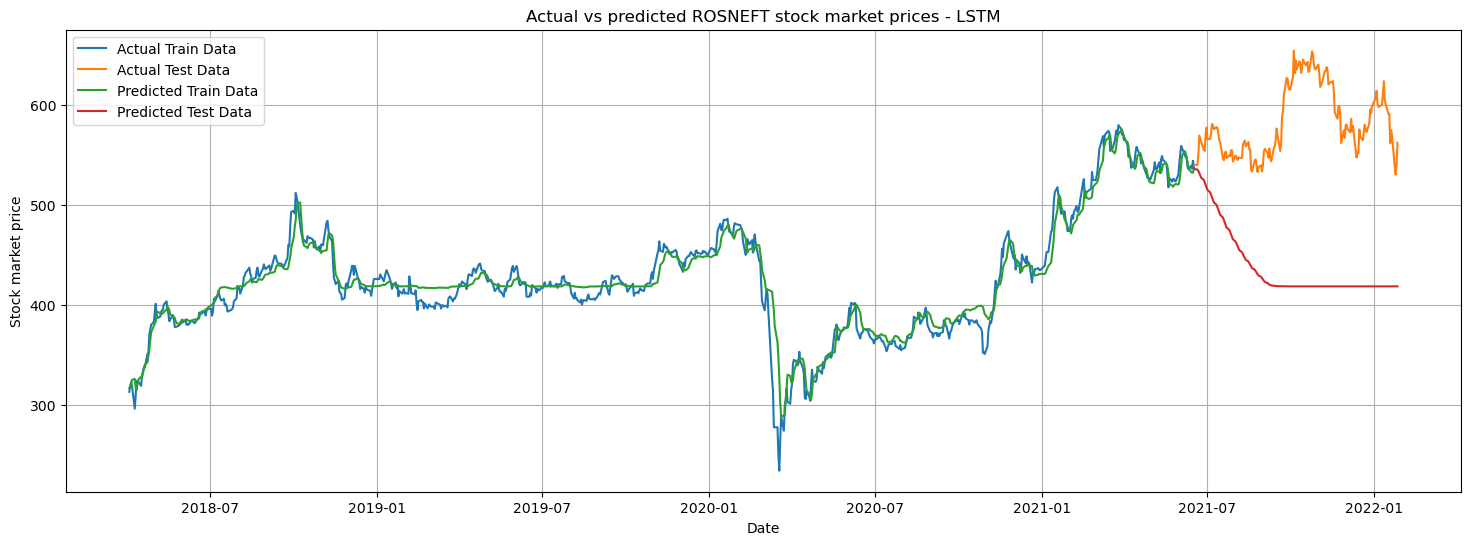

36/36 [==============================] - 1s 17ms/step


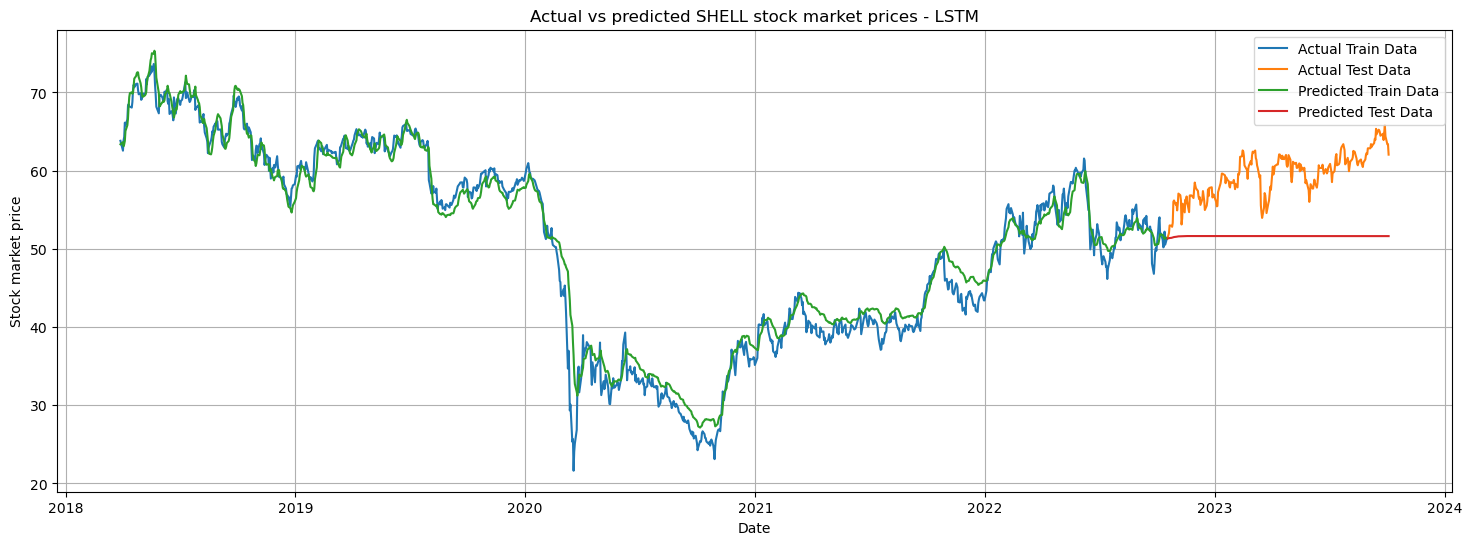

In [10]:
all_metrics = []
for file in pkl_files :    
    company_name = file[:-7]
    
    lstm_metrics = build_lstm(file, sequence_length, split_ratio, N_neurons=80, dropout=0.1, epochs=50, loss='mape')
    lstm_metrics = [company_name, 'LSTM'] + lstm_metrics
    all_metrics.append(lstm_metrics)

### 2- ARIMA

### Exploring stock components and characteristics as a time series

### Stationarity


In the realm of financial markets and stock price analysis, the Augmented Dickey-Fuller (ADF) test plays a pivotal role in addressing a fundamental concern – the stationarity of time series data. The necessity for stationarity arises from its profound impact on the reliability of statistical analyses and predictive modeling. Stationary time series possess statistical properties, such as a constant mean and variance, that remain consistent over time. This constancy is crucial for making accurate predictions and informed decisions in financial forecasting.

The primary purpose of the ADF test is to determine whether a given time series exhibits a unit root, which implies non-stationarity. Non-stationary time series often have trends or seasonality, making them challenging for certain statistical analyses.

The null hypothesis of this test is that the time series has a unit root, indicating non-stationarity. The alternative hypothesis is that the time series is stationary. By comparing the test statistic to critical values, we can decide whether to reject the null hypothesis. 

Particularly,  if the ***p_value < significance_level*** (often chosen as 0.05 we reject H0 and the stock time series is then stationary, otherwise, we keep it and assume that H0 is not stationary.

In [11]:
from statsmodels.tsa.stattools import adfuller


for file in pkl_files:
    close = pd.read_pickle(file)['Close']
    result = adfuller(close)
    p_value = result[1]
    print("**************", file[:-7],"***************")
    if p_value < 0.05:
        print('The H0 hypothesis is rejected, then the corresponding time series is stationary'.format(file[:-7]))
    else:
        print('The H0 hypothesis can not be rejected, then the corresponding time series is not stationary'.format(file[:-7]))

************** Alibaba ***************
The H0 hypothesis can not be rejected, then the corresponding time series is not stationary
************** BNPParibas ***************
The H0 hypothesis can not be rejected, then the corresponding time series is not stationary
************** Google ***************
The H0 hypothesis can not be rejected, then the corresponding time series is not stationary
************** ROSNEFT ***************
The H0 hypothesis can not be rejected, then the corresponding time series is not stationary
************** SHELL ***************
The H0 hypothesis can not be rejected, then the corresponding time series is not stationary


As observed in our case, neither of the time series exhibits stationarity. Consequently, it becomes imperative to address this issue in order to enable accurate and meaningful analyses in subsequent steps.

One effective approach to achieve stationarity is through differencing the time series. Which involves computing the differences between its consecutive values. This transformation can help mitigate trends or seasonality present in the data, making the series more amenable to statistical analyses. By taking the first difference, subtracting each data point from its preceding one, or employing higher-order differencing if needed, we aim to stabilize the mean and variance of the time series.

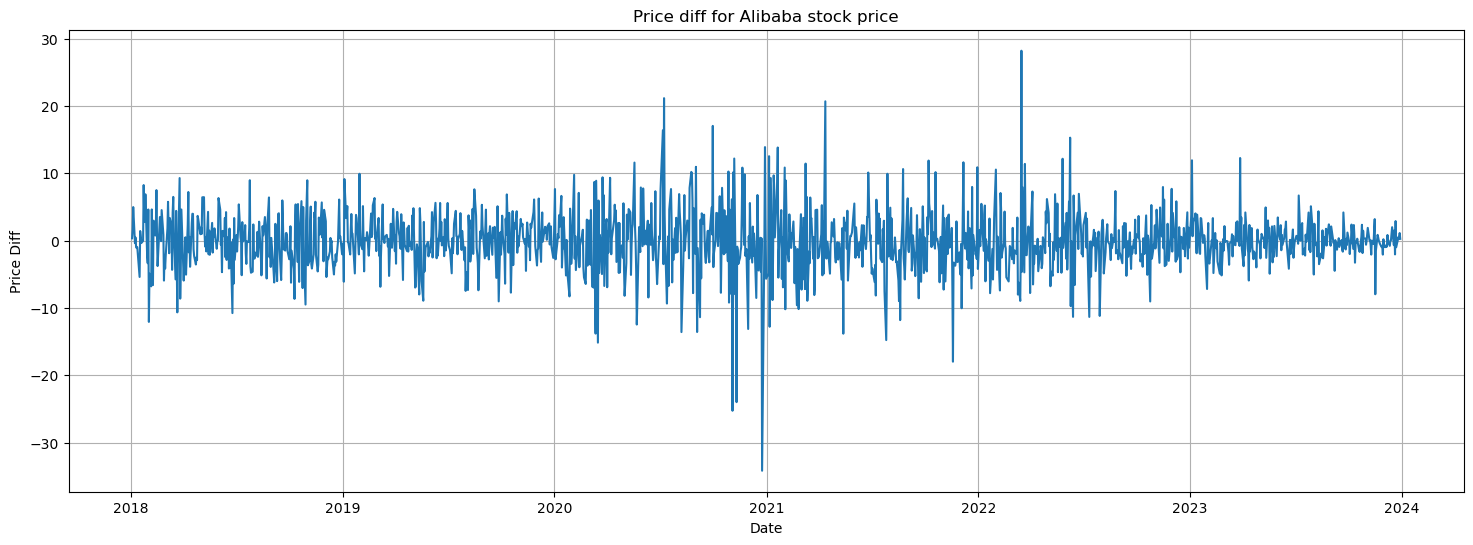

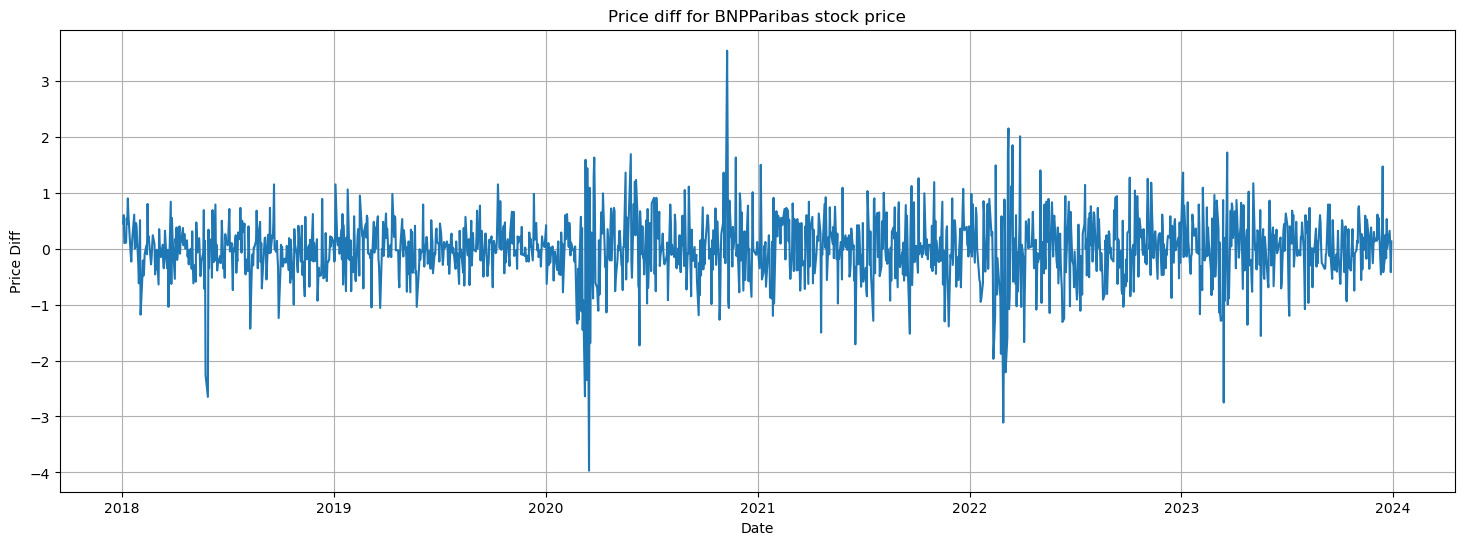

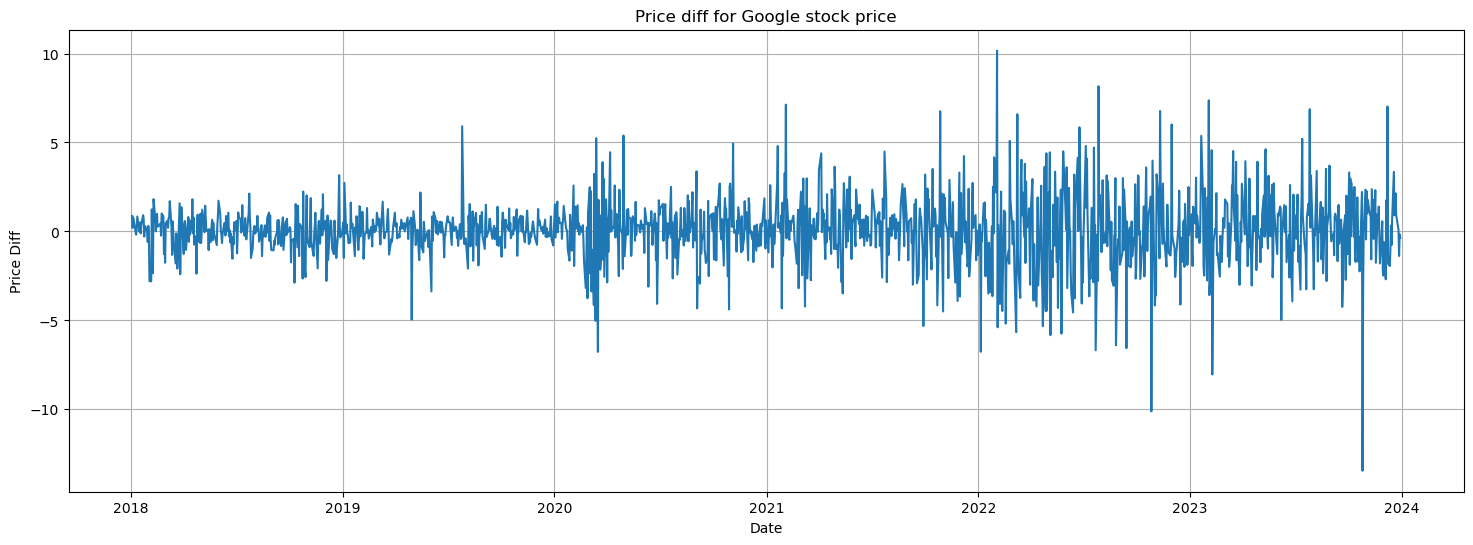

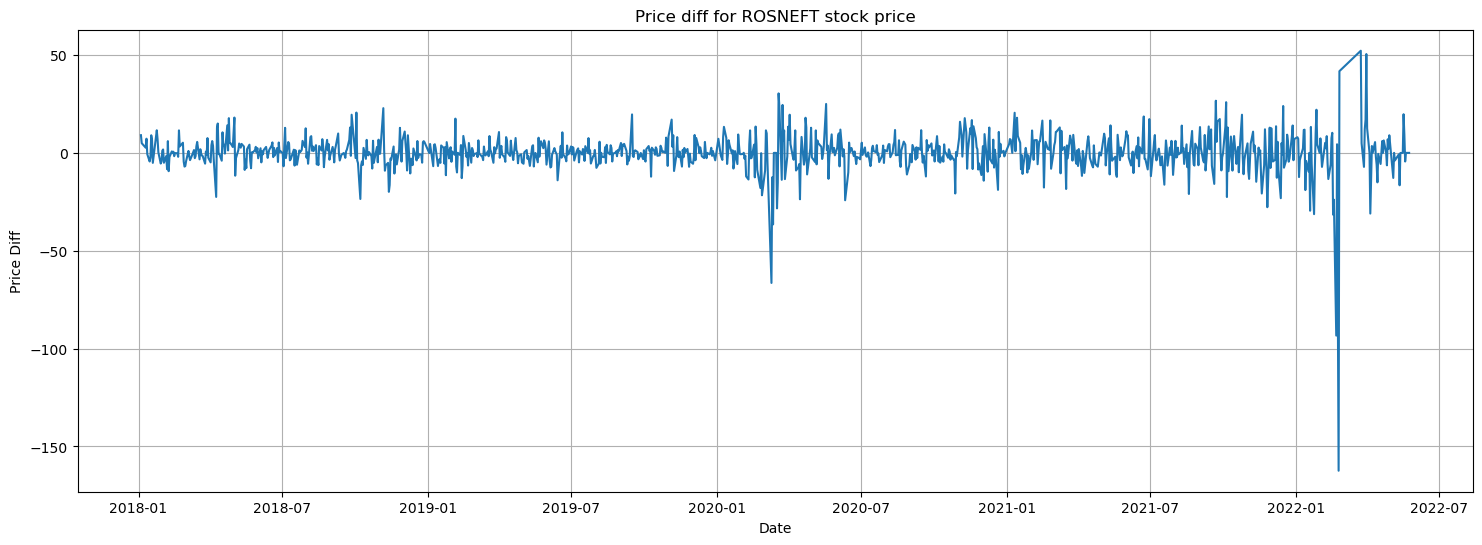

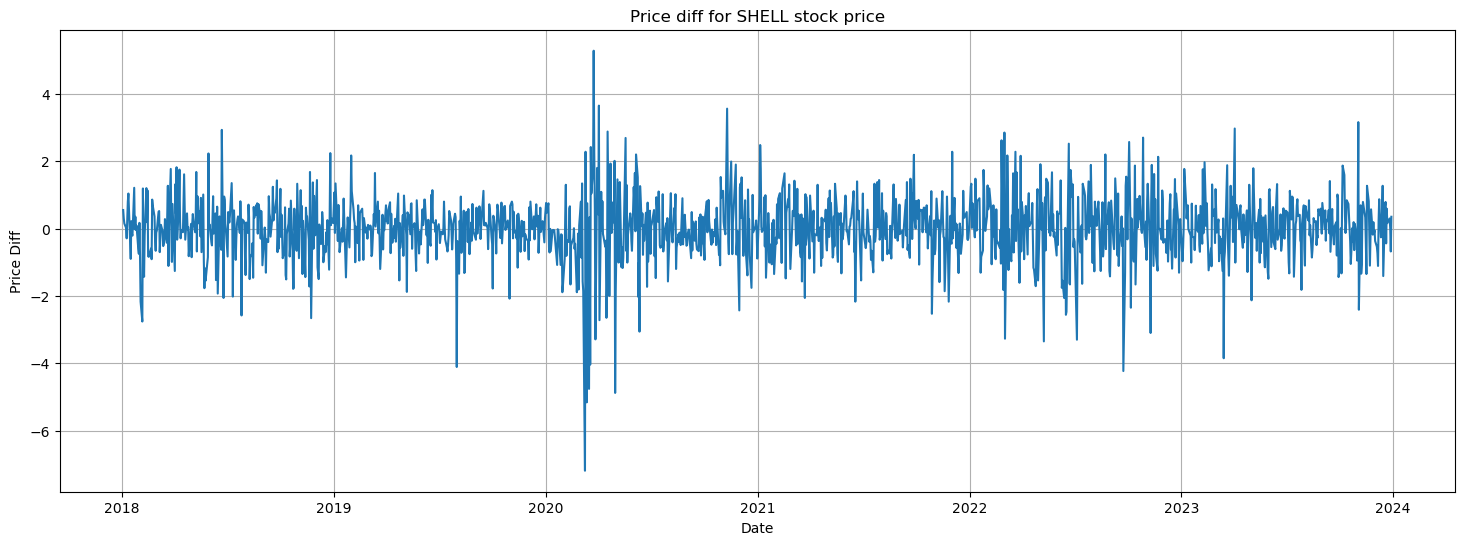

In [12]:
def differentiate(file, data, diff):
    """
    Apply differencing to a time series data and visualize the result.

    Parameters:
    - file (str): Name of the file or stock.
    - data (pd.Series): Time series data.
    - diff (int): Order of differencing.

    Returns:
    None (displays the plot).
    """
    plt.figure(figsize=(18, 6))
    plt.grid()
    # Apply differencing to the data
    data_diff = data.diff(diff)
    # Plot the differenced data
    plt.plot(data_diff)
    # Set labels and title
    plt.xlabel("Date")
    plt.ylabel("Price Diff")
    plt.title("Price diff for {} stock price".format(file[:-7]))
    # Display the plot
    plt.show()

    
for file in pkl_files:
    close = pd.read_pickle(file)['Close']
    differentiate(file, close, 1)

As we can see, our differenced time series are now much more stable, however, it is essential to reevaluate the stationarity of the transformed series using tools like the Augmented Dickey-Fuller (ADF) test to be sure.

In [13]:
for file in pkl_files:
    close = pd.read_pickle(file)['Close'].diff().dropna()
    result = adfuller(close)
    p_value = result[1]
    print("**************", file[:-7],"***************")
    if p_value < 0.05:
        print('The H0 hypothesis is rejected, then the corresponding time series is stationary'.format(file[:-7]))
    else:
        print('The H0 hypothesis can not be rejected, then the corresponding time series is not stationary'.format(file[:-7]))

************** Alibaba ***************
The H0 hypothesis is rejected, then the corresponding time series is stationary
************** BNPParibas ***************
The H0 hypothesis is rejected, then the corresponding time series is stationary
************** Google ***************
The H0 hypothesis is rejected, then the corresponding time series is stationary
************** ROSNEFT ***************
The H0 hypothesis is rejected, then the corresponding time series is stationary
************** SHELL ***************
The H0 hypothesis is rejected, then the corresponding time series is stationary


As expected, differencing the stock markets by 1 makes them stationary at a 5% significance level.

This could be confirmed also by using the ndiffs method drom pmdarima.arima.utils , which can be based on any chosen test( here adfuller).

In [14]:
from pmdarima.arima.utils import ndiffs

print("The suggested number of differenciation for :")
for file in pkl_files:
    close = pd.read_pickle(file)['Close']
    print("***", file[:-7], "*** :", ndiffs(close, test='adf'))

The suggested number of differenciation for :
*** Alibaba *** : 1
*** BNPParibas *** : 1
*** Google *** : 1
*** ROSNEFT *** : 1
*** SHELL *** : 1


The next step in our analysis in determining the order p and q of the model ARIMA that will be used for the forecasting.

The forecasting model we will be using is ARIMA, which stands for AutoRegressive Integrated Moving Average. It is a popular time series forecasting model that combines elements of autoregression (AR), differencing (I for Integrated), and moving averages (MA). It is designed to capture different aspects of time series data, including trends and seasonality.

* **p (AR - AutoRegressive order):** This parameter represents the number of autoregressive terms in the model. Autoregressive terms refer to the dependence of the current value on its past values. A higher value of p indicates a longer memory of past values in the model. For example, an ARIMA(p, d, q) model with p=2 would include the current value's dependence on the two previous time points.

* **d (I - Integrated order):** This parameter represents the number of times differencing is applied to the time series data to achieve stationarity. Differencing involves computing the differences between consecutive observations. A higher value of d signifies a more significant effort to make the data stationary. If the original time series is already stationary, d would be 0. **This parameter is the one we were searching for earlier while testing the stationarity of our data and it is equal to 1 in our case**

* **q (MA - Moving Average order):** This parameter represents the number of moving average terms in the model. Moving averages capture the relationship between the current value and a residual error from the past. A higher value of q indicates a longer memory of past residual errors. For instance, an ARIMA(p, d, q) model with q=1 would involve a moving average term based on the one previous residual error.

Determining the appropriate values for the ARIMA parameters, p and q, typically involves analyzing the autocorrelation function (ACF) and partial autocorrelation function (PACF) plots derived from the time series data.

-The general approach is as follows:

* p (AR order): The cut-off point in the PACF plot(the first lag value where it crosses the significance threshold).

* q (MA order): The cut-off point in the ACF plot (the first lag value where it crosses the significance threshold).


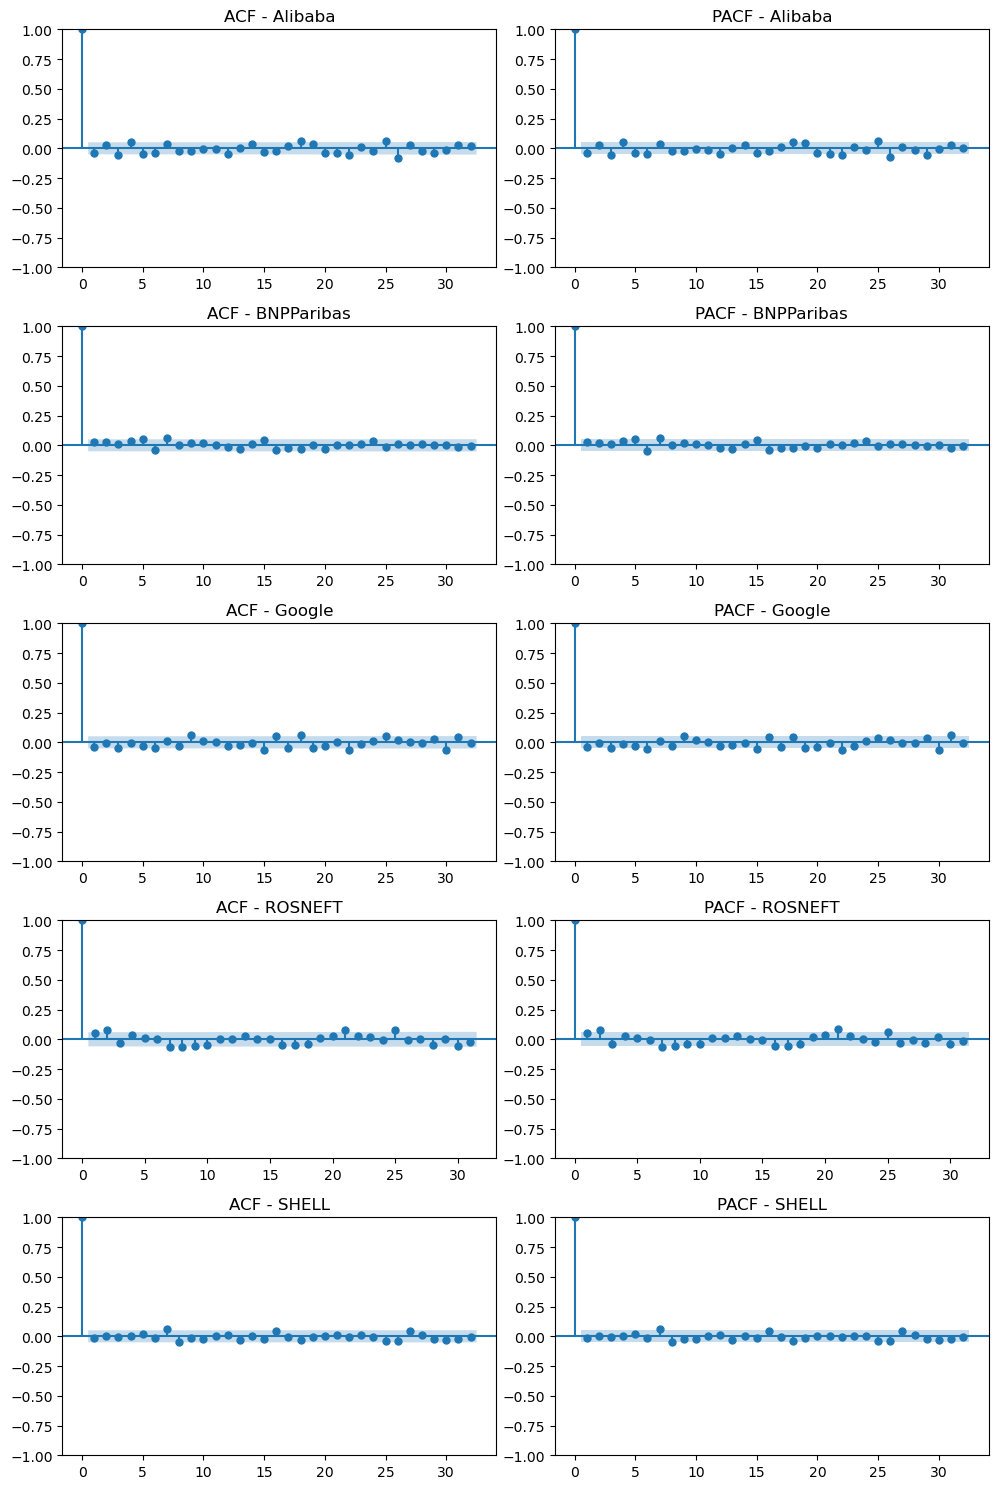

In [15]:
# Create subplots with 5 rows and 2 columns in a 10x15-inch figure
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 15))

# Function to plot ACF and PACF for the differenced data
def plot_acf_pacf(data, ax):
    # Plot Autocorrelation Function (ACF) for differenced data
    plot_acf(data.diff().dropna(), ax=axes[i, 0], title="ACF - {}".format(file[:-7]))

    # Plot Partial Autocorrelation Function (PACF) for differenced data
    plot_pacf(data.diff().dropna(), ax=axes[i, 1], title="PACF - {}".format(file[:-7]))

# Iterate through companies
for i, file in enumerate(pkl_files):
    # Load data for the current company
    company_data = pd.read_pickle(file)
    
    # Extract the 'Close' prices
    close = company_data['Close']
    
    # Call the function to plot ACF and PACF for the current company's 'Close' prices
    plot_acf_pacf(close, axes)

# Adjust layout for better visualization
plt.tight_layout()

# Display the plot
plt.show()


From the plots above, we can deduce the orders of the ARIMA model that we will be using for the forecasting part. The cutoff point appears directly after the first lag for all the companies stocks. Therefore, the values p=1 and q=1 seem well-suited to use in order to obtain accurate results, hopefully.

The last part in our pre-analysis is to determine wether there is a seasonal pattern in our time series or not. Detecting seasonality helps uncover periodic trends and patterns that may influence the data. One common method to identify seasonality is by utilizing seasonal decomposition techniques, such as the one we used here :

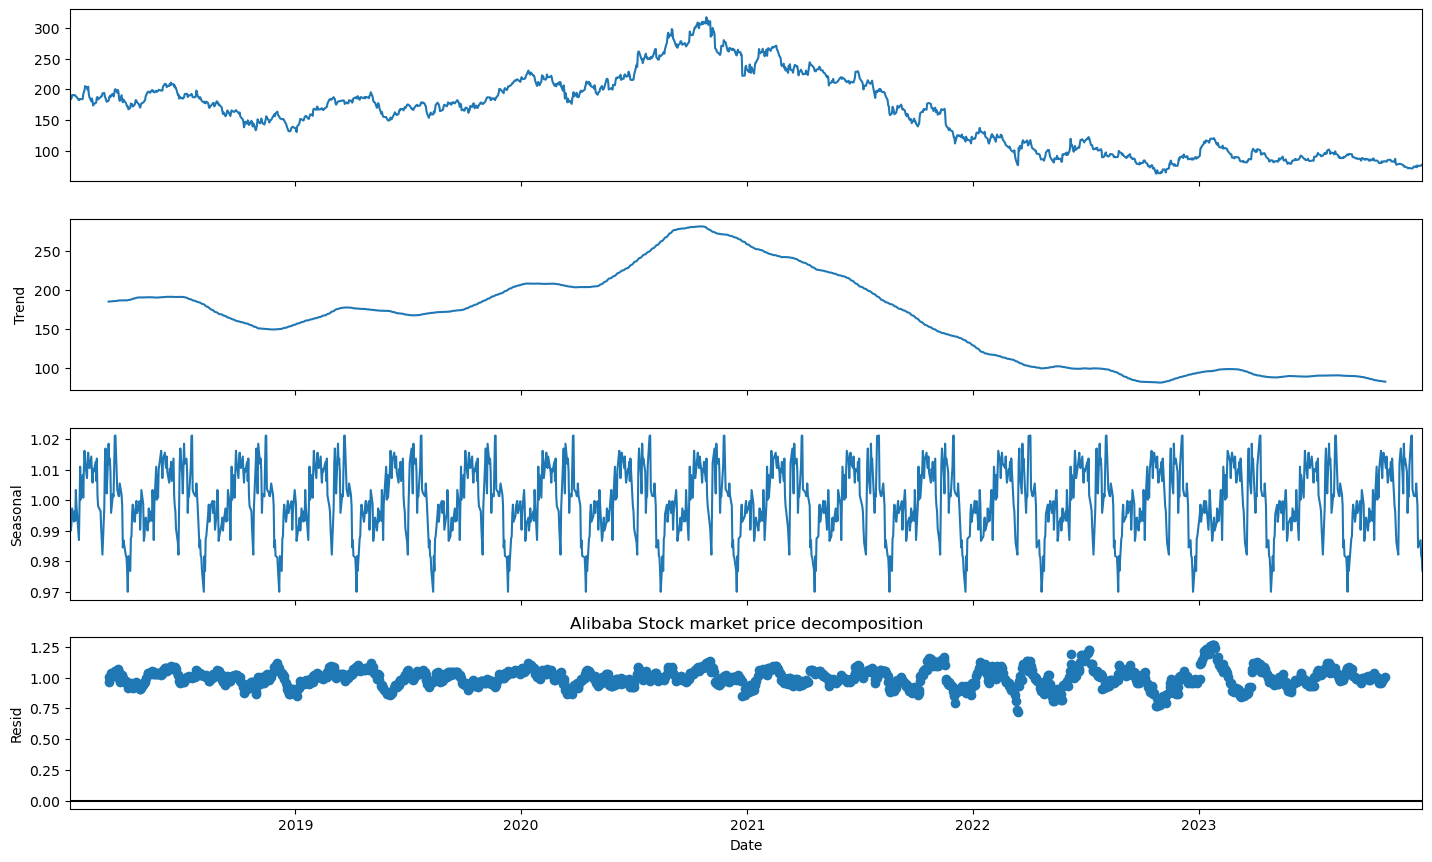

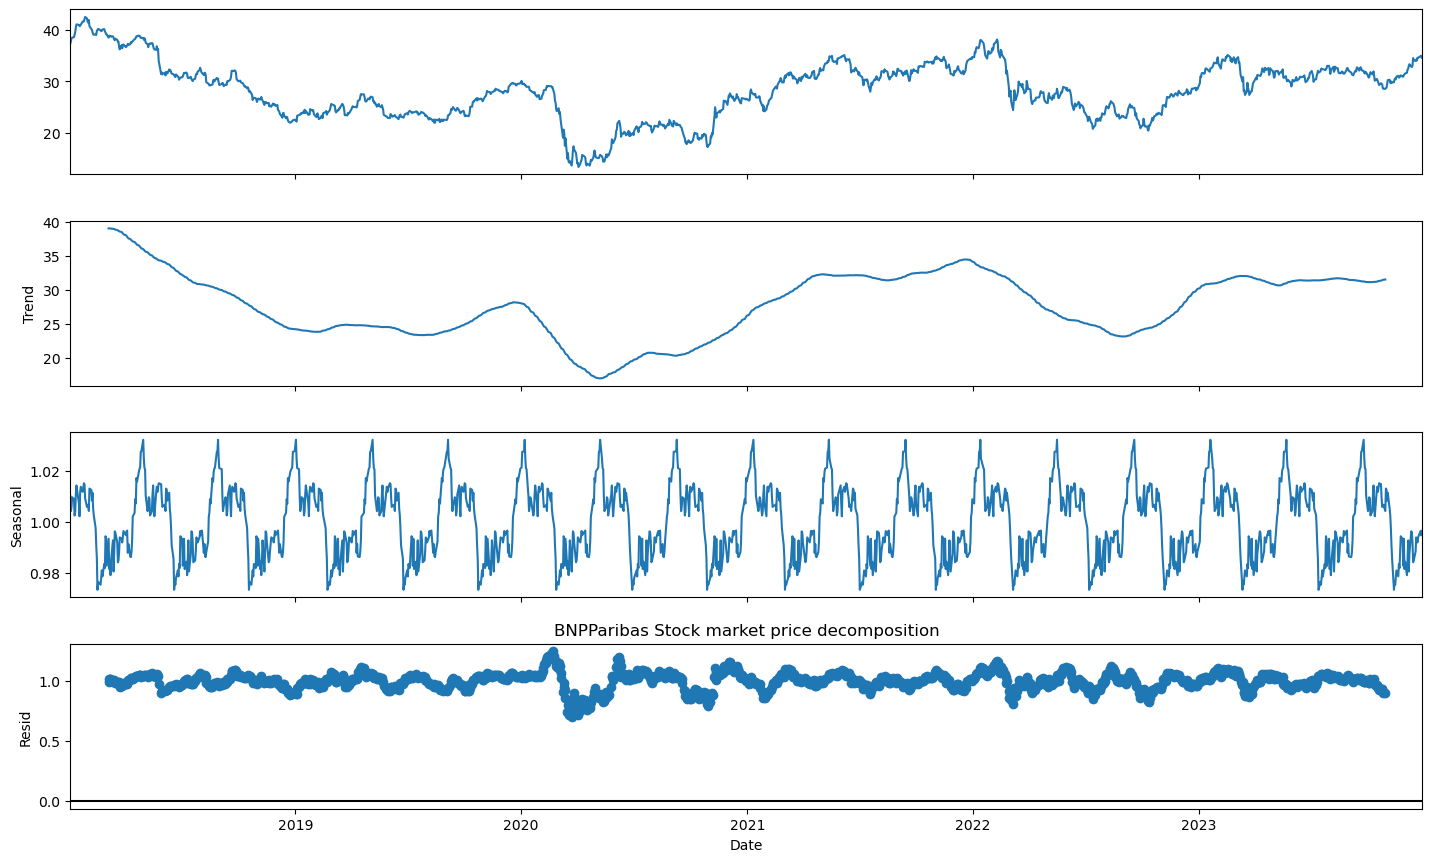

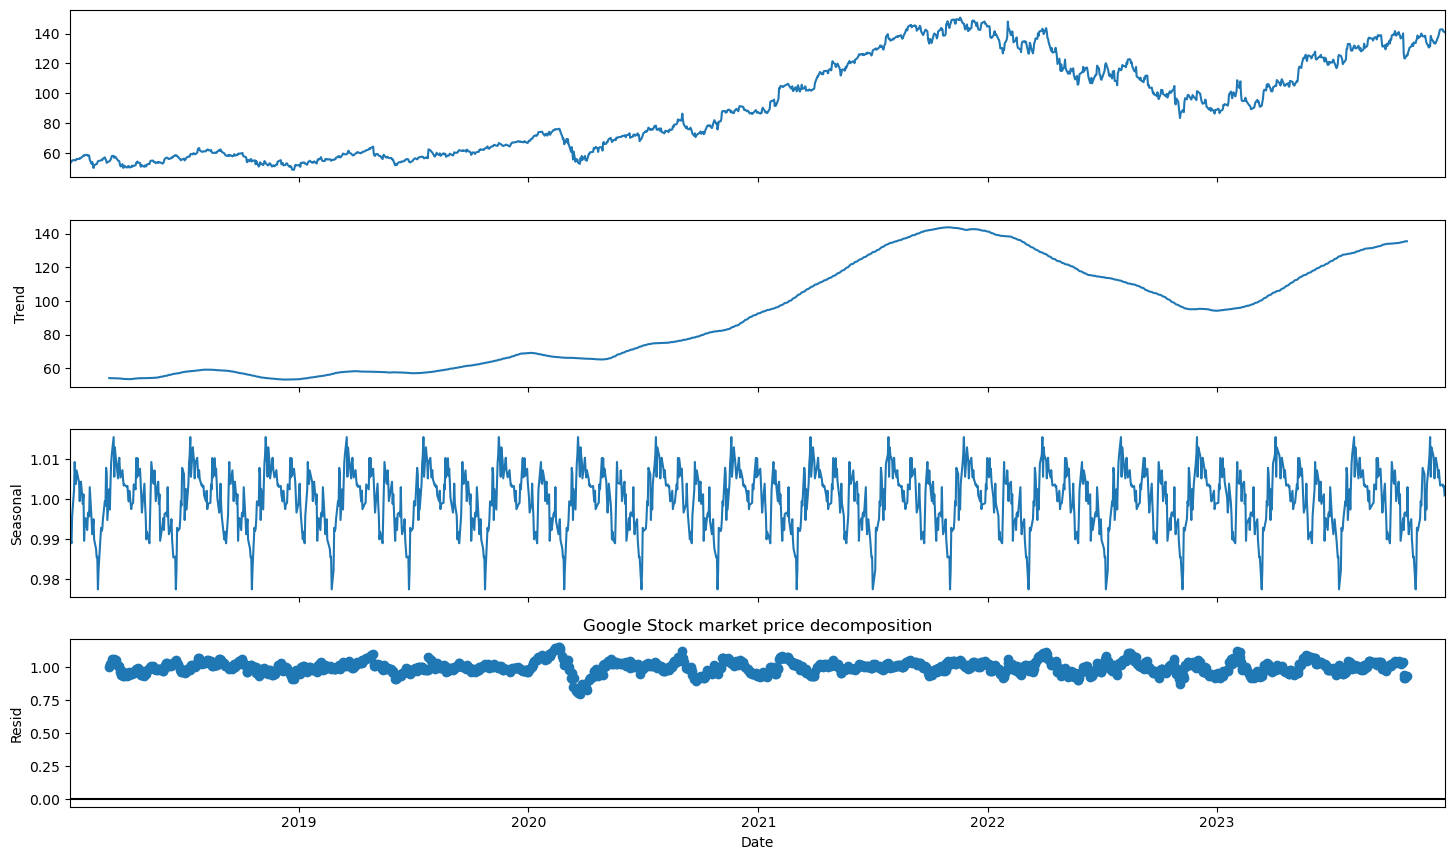

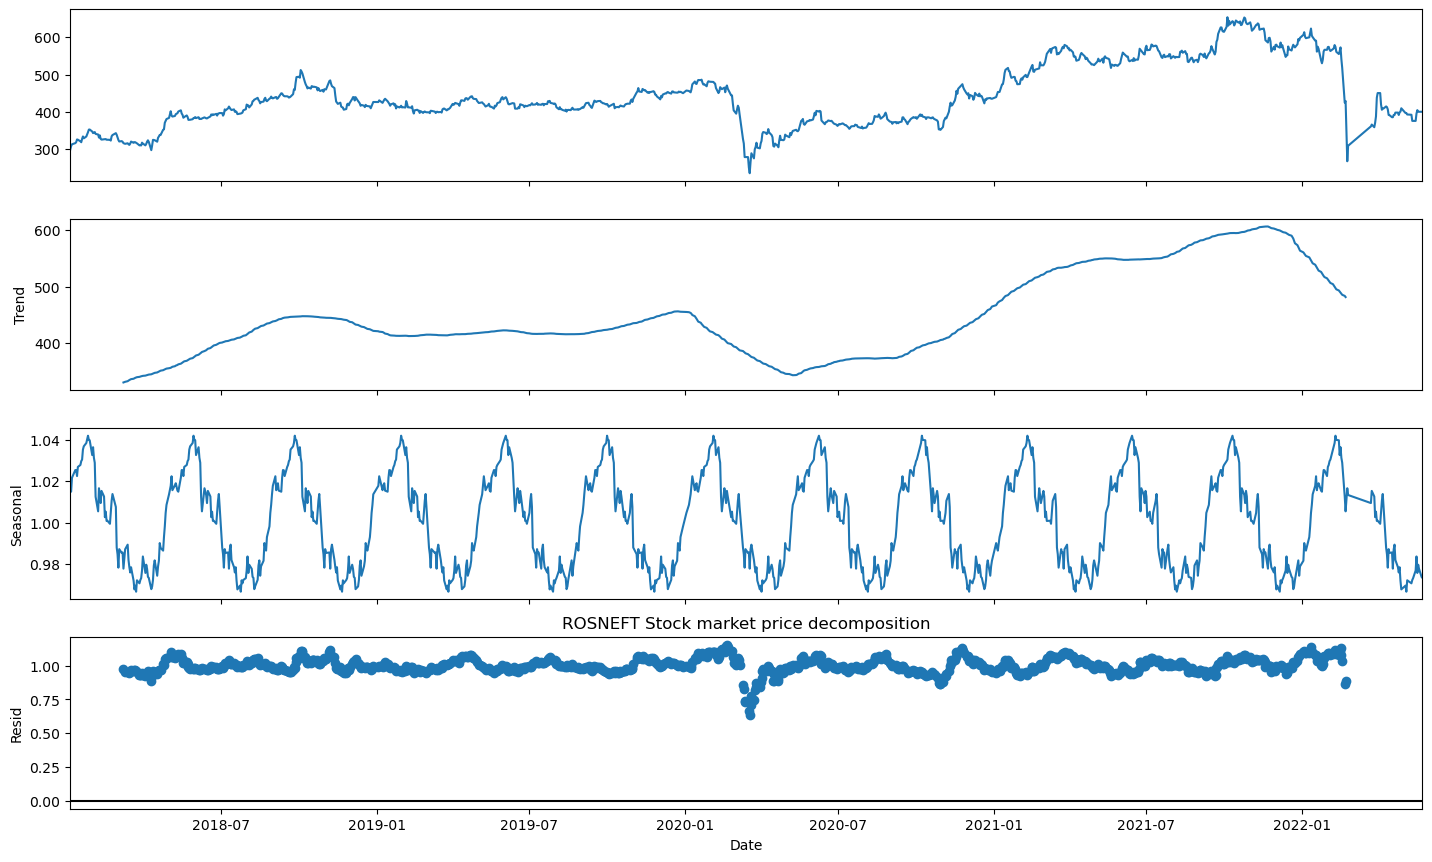

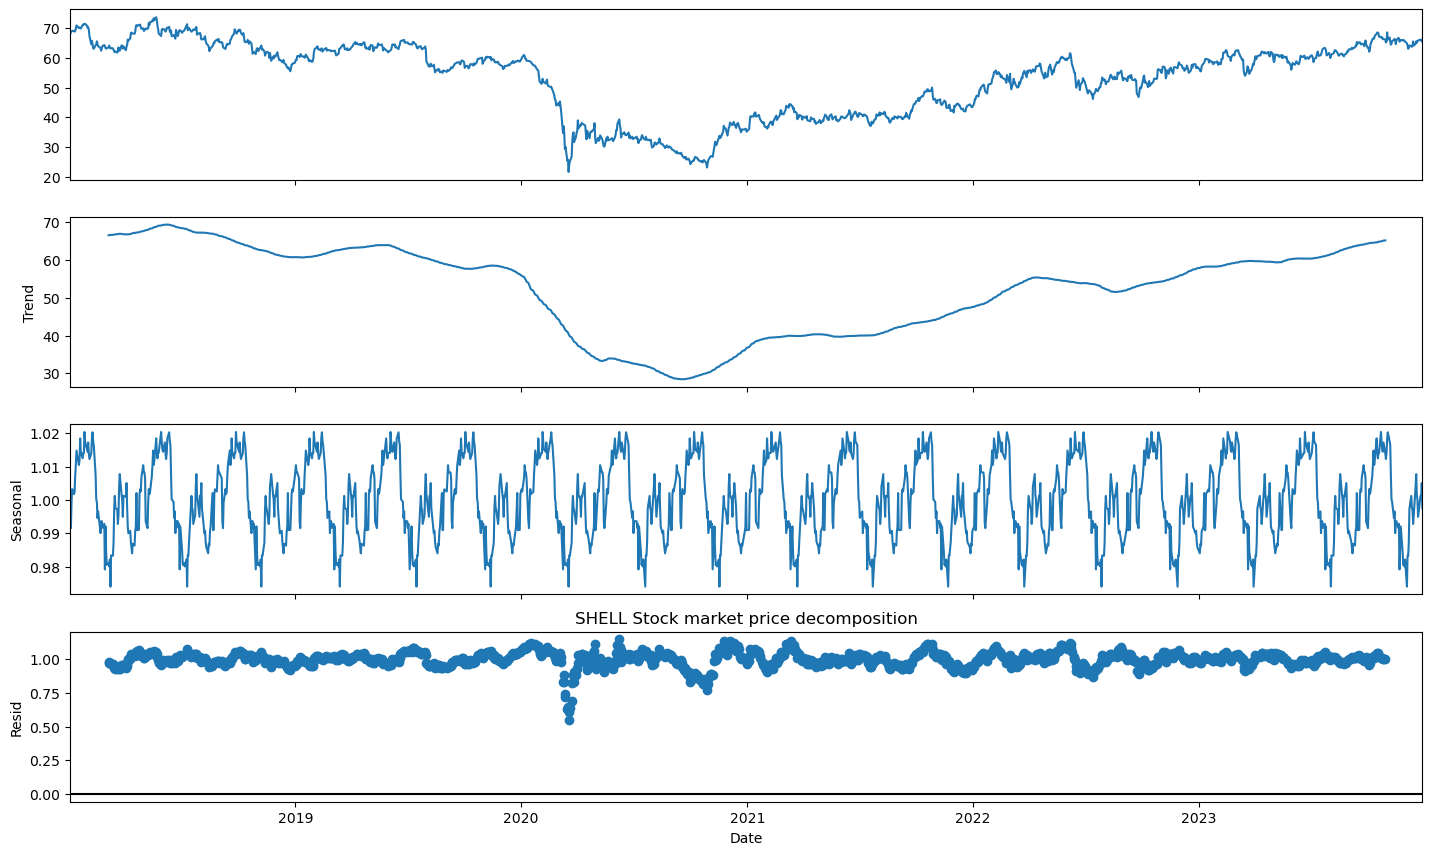

In [16]:
def decompose(file, data, model, period):
    decomposition = seasonal_decompose(data, model=model, period = period)
    fig = decomposition.plot()
    fig.set_size_inches((16, 9))
    plt.title("{} Stock market price decomposition".format(file[:-7]))
    plt.xlabel("Date")
    plt.show()

for file in pkl_files:
    close = pd.read_pickle(file)[['Close']]
    decompose(file, close, model='multiplicative', period = 85)

By analyzing the time series thoroughly, we can confidently assert that there is no apparent and consistent seasonal pattern. While there are some recurrent cyclic peaks, they lack a well-defined and consistent period. These peaks seem somewhat irregular, with a tendency to appear quarterly. Therefore, in the absence of a clearly identified and fixed pattern, our best approach is to make an assumption of yearly and quarterly seasonality in our analysis.

In [17]:
def plot_arima(df_train, df_test, forecast_test, conf_int, file):
    """
    Plot actual vs predicted stock market prices using ARIMA forecasting.

    Parameters:
    - df_train (pd.Series): Training data for the time series.
    - df_test (pd.Series): Test data for the time series.
    - forecast_test (pd.Series): Predictions from ARIMA model on the test data.
    - conf_int (np.ndarray): Confidence intervals for ARIMA predictions.
    - file (str): Name of the stock for plot title.

    Returns:
    None (displays the plot).
    """
    plt.figure(figsize=(18, 6))
    plt.grid()
    
    # Plot training and test data
    plt.plot(df_train, label='Training data')
    plt.plot(df_test, color='blue', label='Test data')
    
    # Plot ARIMA prediction
    plt.plot(df_test.index, forecast_test, color='red', label='ARIMA prediction')
    
    # Plot confidence intervals for ARIMA
    plt.fill_between(df_test.index, conf_int[:, 0], conf_int[:, 1], color='red', alpha=0.2, label='ARIMA CI')
    
    plt.title("Actual vs predicted {} stock market prices - ARIMA ".format(file[:-7]))
    plt.xlabel('Date')
    plt.ylabel('Stock market price')
    plt.legend()
    plt.show()

def Arima(file, split_ratio, p, d, q, verbose=True):
    """
    Perform ARIMA forecasting on stock market data.

    Parameters:
    - file (str): Name of the file containing stock market data.
    - split_ratio (float): Ratio to split the data into training and testing sets.
    - p (int): ARIMA parameter for autoregressive order.
    - d (int): ARIMA parameter for integrated order.
    - q (int): ARIMA parameter for moving average order.
    - verbose (bool): Whether to print information and plot results.

    Returns:
    - list: Metrics including MAE, MAPE, RMSE, and training time for ARIMA model.
    """
    start_time = time.time()
    # Read stock market data
    data = pd.read_pickle(file)

    # Split data into training and testing sets
    df_close = data['Close']
    split_index = int(len(df_close) * split_ratio)
    df_train = df_close[:split_index]
    df_test = df_close[split_index:]
    
    # ARIMA
    model = ARIMA(df_train, order=(p, d, q))
    model_fit = model.fit()
    training_time = time.time() - start_time

    # Get forecast and confidence intervals for ARIMA
    forecast = model_fit.get_forecast(steps=len(df_test)).summary_frame()
    forecast_test = forecast['mean']
    conf_int = forecast[['mean_ci_lower', 'mean_ci_upper']].values

    # Calculate metrics for ARIMA
    mae, mape, rmse = calculate_metrics(df_test.values.flatten(), forecast_test)

    if verbose:
        plot_arima(df_train, df_test, forecast_test, conf_int, file)

    return [mae, mape, rmse, training_time]


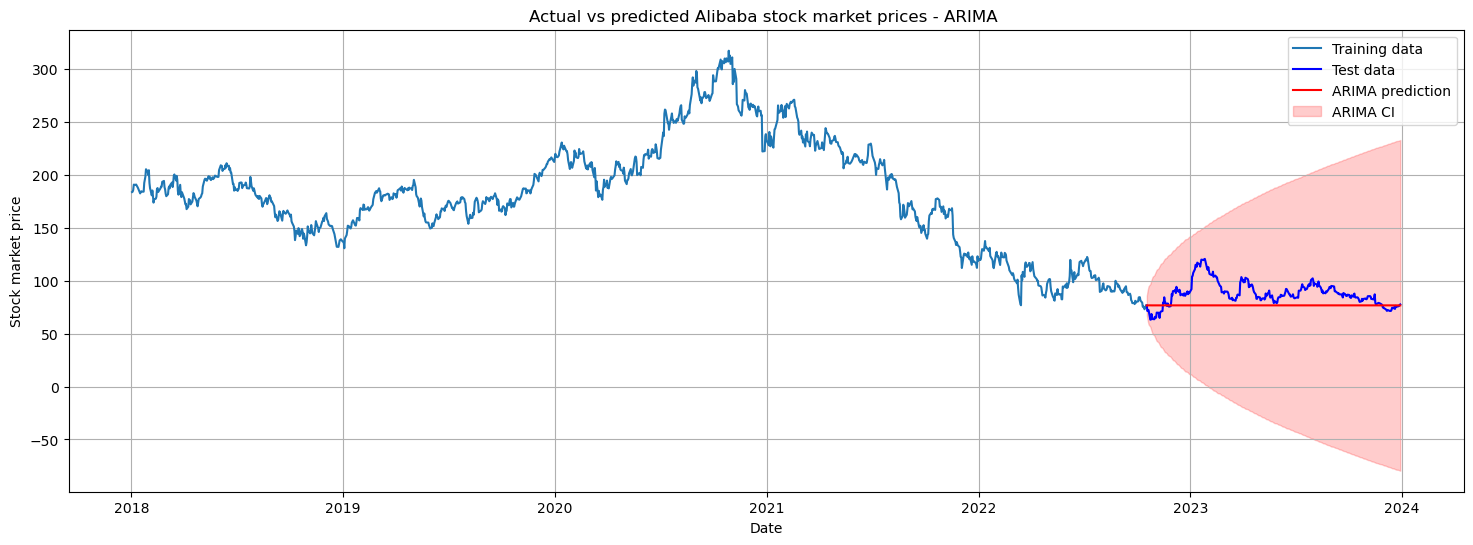

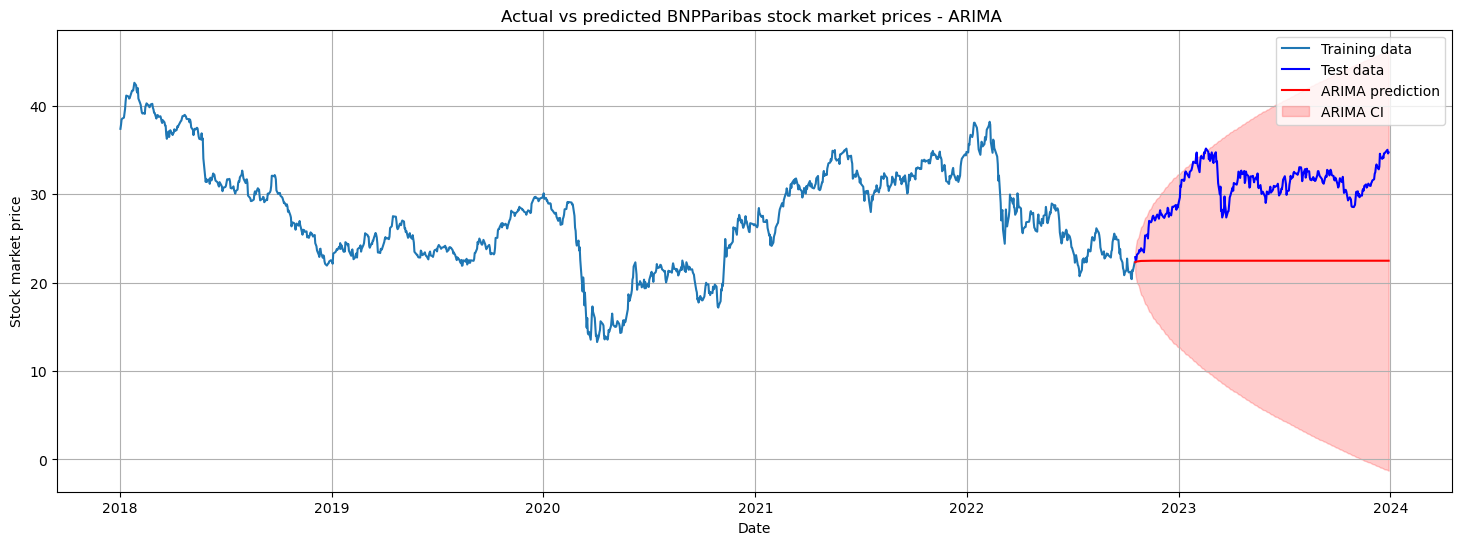

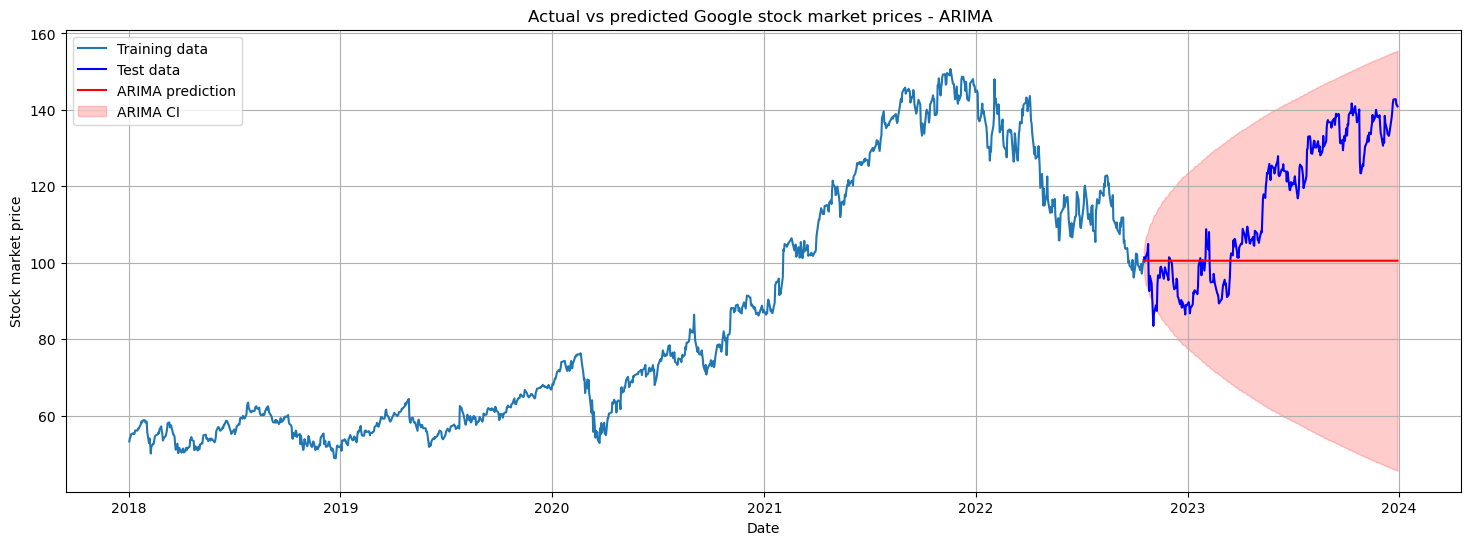

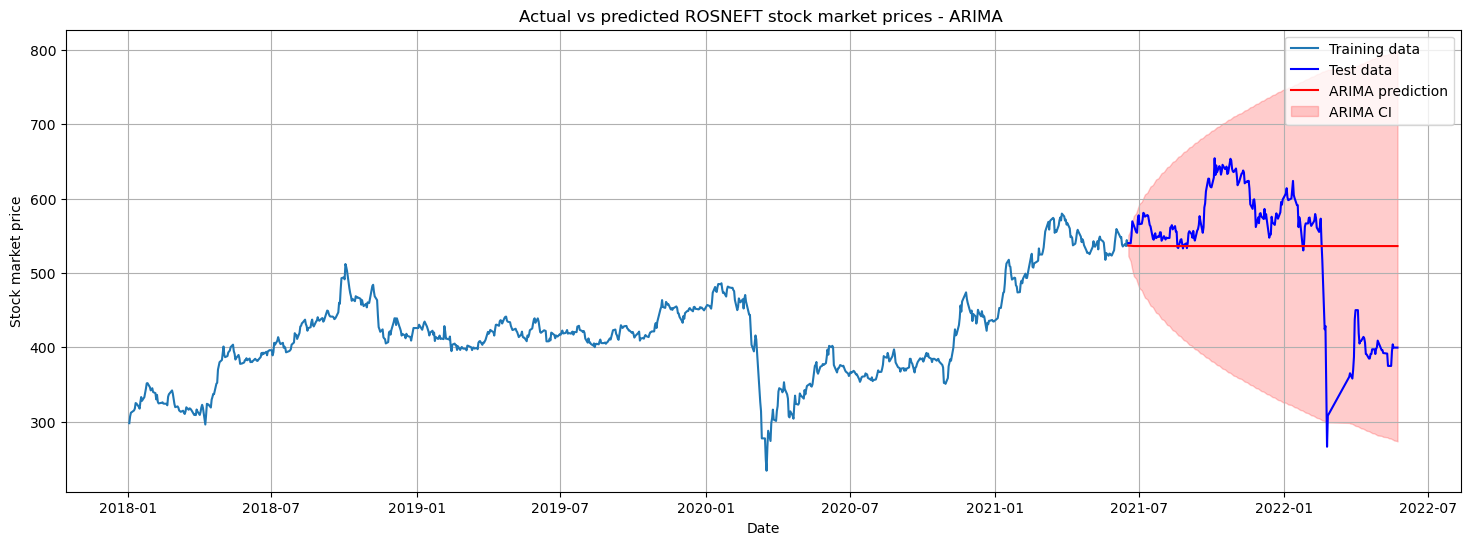

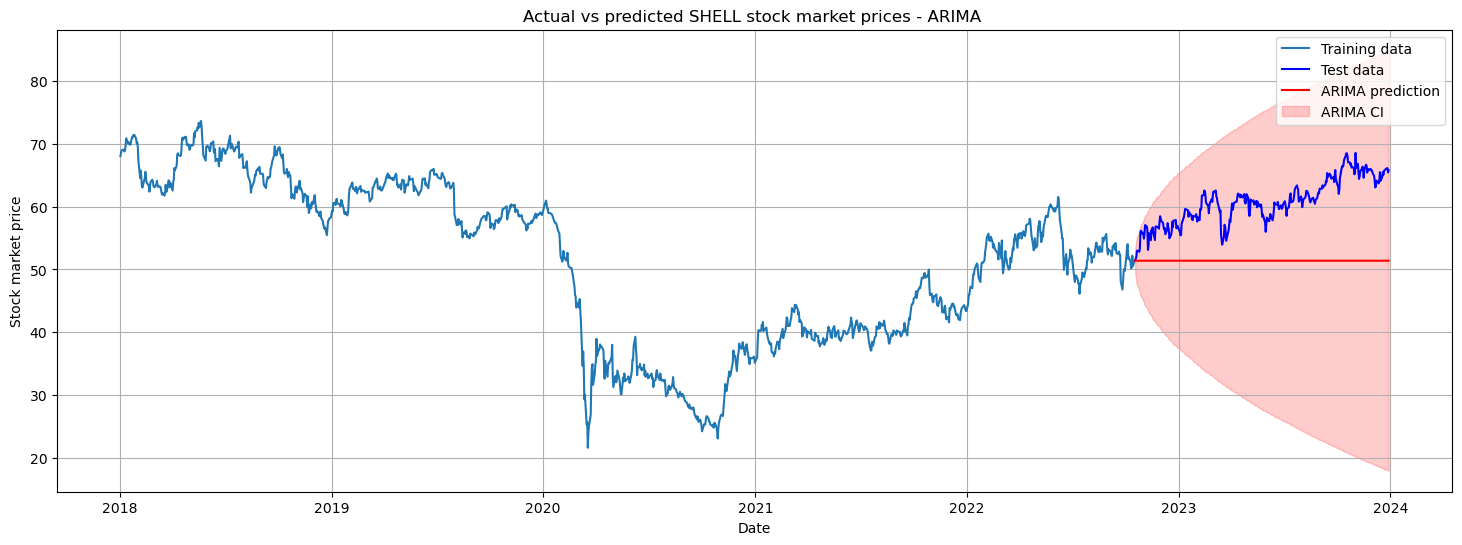

In [18]:
for file in pkl_files:
    company_name = file[:-7]
    
    arima_metrics = Arima(file, 0.8, 1, 1, 1)
    arima_metrics = [company_name, 'ARIMA'] + arima_metrics
    
    all_metrics.append(arima_metrics)

### 3- Prophet model


In this final phase, we will be testing the performance of a well-known forecasting model, the Prophet model. Prophet is a robust time series forecasting tool developed by Facebook, designed to handle daily observations with strong seasonal patterns and multiple seasonality components. The model incorporates yearly, weekly and daily seasonality and can also accommodate holidays.

To begin, we load the stock market data and split it into training and testing sets. The Prophet model is then instantiated and trained using the historical data. One noteworthy aspect of Prophet is its ability to account for special events or holidays that may impact stock prices. Following the model training, we generate predictions for the test set and evaluate its performance using standard metrics such as Mean Absolute Error (MAE), Mean Absolute Percentage Error (MAPE), and Root Mean Squared Error (RMSE).

In [19]:
from prophet import Prophet

def plot_prophet(df_train, df_test, forecast, days_difference, file):
    """
    Plot actual vs predicted stock market prices using Prophet.

    Parameters:
    - df_train (DataFrame): DataFrame containing training data.
    - df_test (DataFrame): DataFrame containing test data.
    - forecast (DataFrame): Forecast generated by Prophet.
    - days_difference (int): Number of days in the future to predict.
    - file (str): Name of the file containing stock market data.
    """
    plt.figure(figsize=(18, 6))
    plt.grid()
    
    # Plot actual values and predictions for training data
    plt.plot(df_train['ds'], df_train['y'], label='Actual Train', color='blue')
    plt.plot(df_train['ds'], forecast['yhat'][:len(df_train)], label='Predicted Train', color='orange')
    
    # Plot actual values and predictions for test data
    plt.plot(df_test['ds'], df_test['y'], label='Actual Test', color='green')
    plt.plot(forecast['ds'][-days_difference:], forecast['yhat'][-days_difference:], label='Predicted Test', color='red')
    
    plt.title("Actual vs predicted {} stock market prices - PROPHET ".format(file[:-7]))
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()


def prophet_model(file, split_ratio, verbose=True):
    """
    Build and train a Prophet model for stock market price prediction.

    Parameters:
    - file (str): Name of the file containing stock market data.
    - split_ratio (float): Ratio to split the data into training and testing sets.
    - verbose (bool): Whether to display the plot and print information.

    Returns:
    - list: Metrics including MAE, MAPE, RMSE, and training time.
    """
    start_time = time.time()
    
    # Read stock market data
    data = pd.read_pickle(file)
    df_close = data['Close']
    
    # Create a DataFrame with 'ds' and 'y' columns
    data = pd.DataFrame({'ds': df_close.index, 'y': df_close.values})
    
    # Split data into training and testing sets
    split_index = int(len(data) * split_ratio)
    df_train = data[:split_index]
    df_test = data[split_index:]
    
    # Calculate the number of days to predict in the future
    last_date_data = data['ds'].max()
    last_date_df_train = df_train['ds'].max()
    days_difference = (last_date_data - last_date_df_train).days
    
    # Initialize the Prophet model
    model = Prophet(
        changepoint_prior_scale = 10,
        seasonality_prior_scale = 3,
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False
    )
    model.add_seasonality(name='quarterly', period=85, fourier_order=5)
    
    # Fit the model with training data
    model.fit(df_train)
    
    # Create a DataFrame with future dates for prediction
    future = model.make_future_dataframe(periods=days_difference, freq='D')
    training_time = time.time() - start_time
    # Make predictions on the test set
    forecast = model.predict(future)
    
    # Calculate metrics
    actual_test = df_test['y'].values
    predicted_test = forecast['yhat'][-len(df_test):].values
    mae, mape, rmse = calculate_metrics(actual_test, predicted_test)
    
    # Plot actual values and predictions for train and test data
    if verbose:
        plot_prophet(df_train, df_test, forecast, days_difference, file)
    
    # Return metrics
    return [mae, mape, rmse, training_time]


11:23:28 - cmdstanpy - INFO - Chain [1] start processing
11:23:28 - cmdstanpy - INFO - Chain [1] done processing


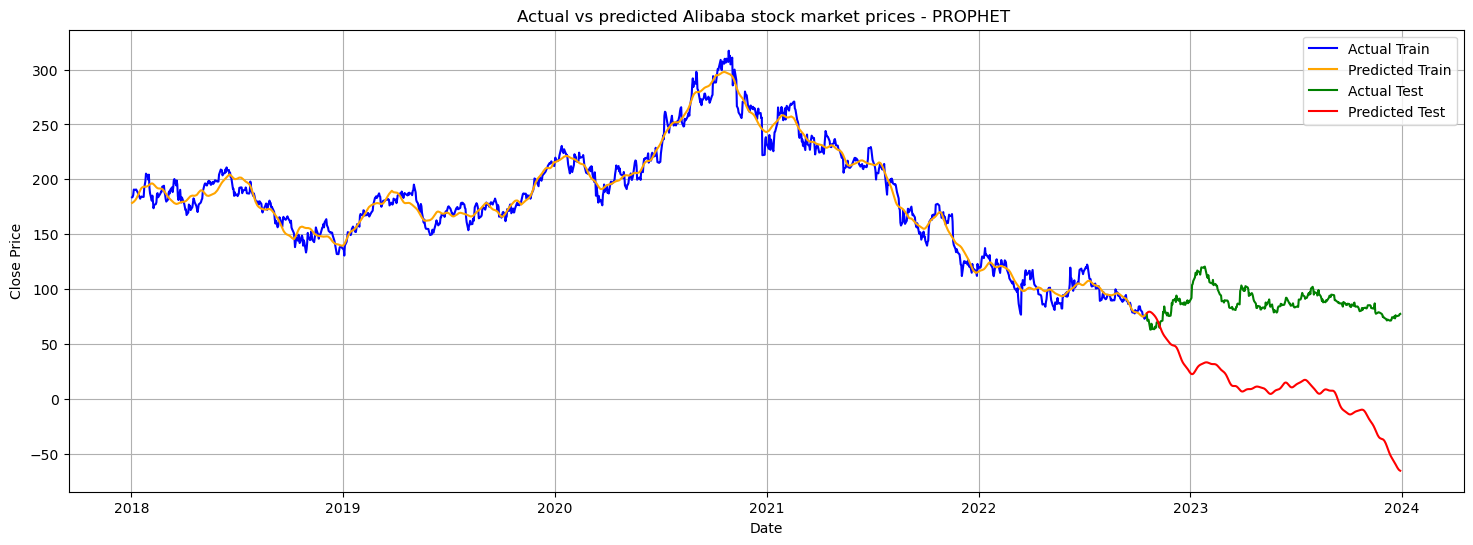

11:23:29 - cmdstanpy - INFO - Chain [1] start processing
11:23:30 - cmdstanpy - INFO - Chain [1] done processing


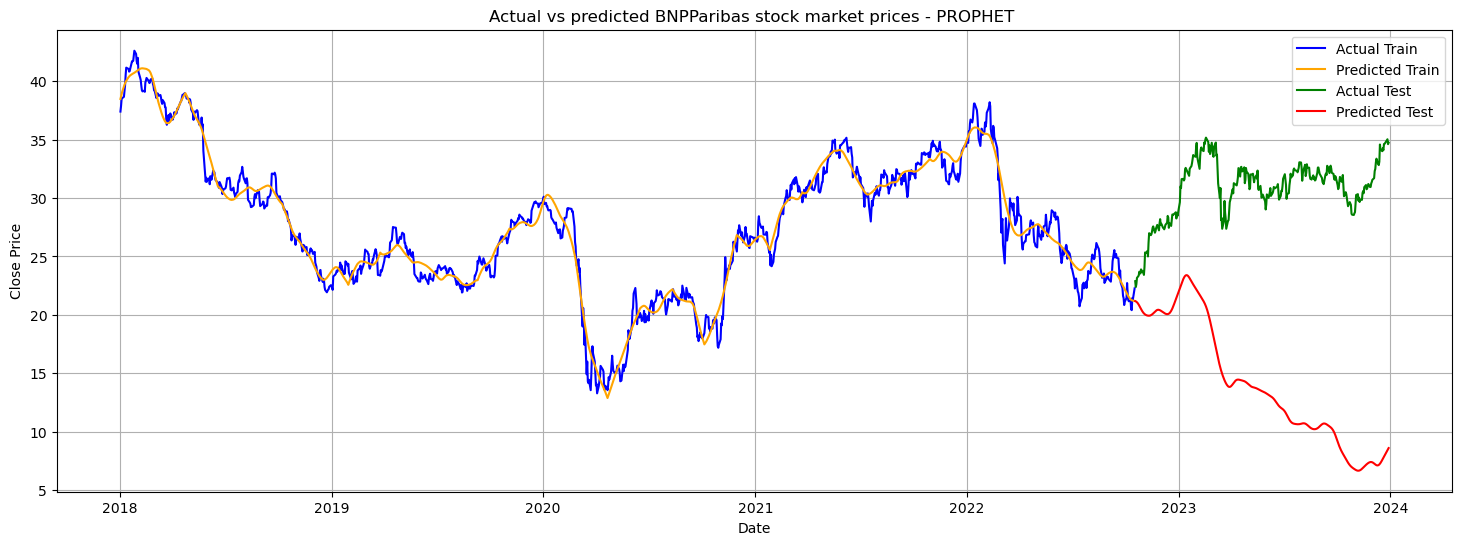

11:23:31 - cmdstanpy - INFO - Chain [1] start processing
11:23:32 - cmdstanpy - INFO - Chain [1] done processing


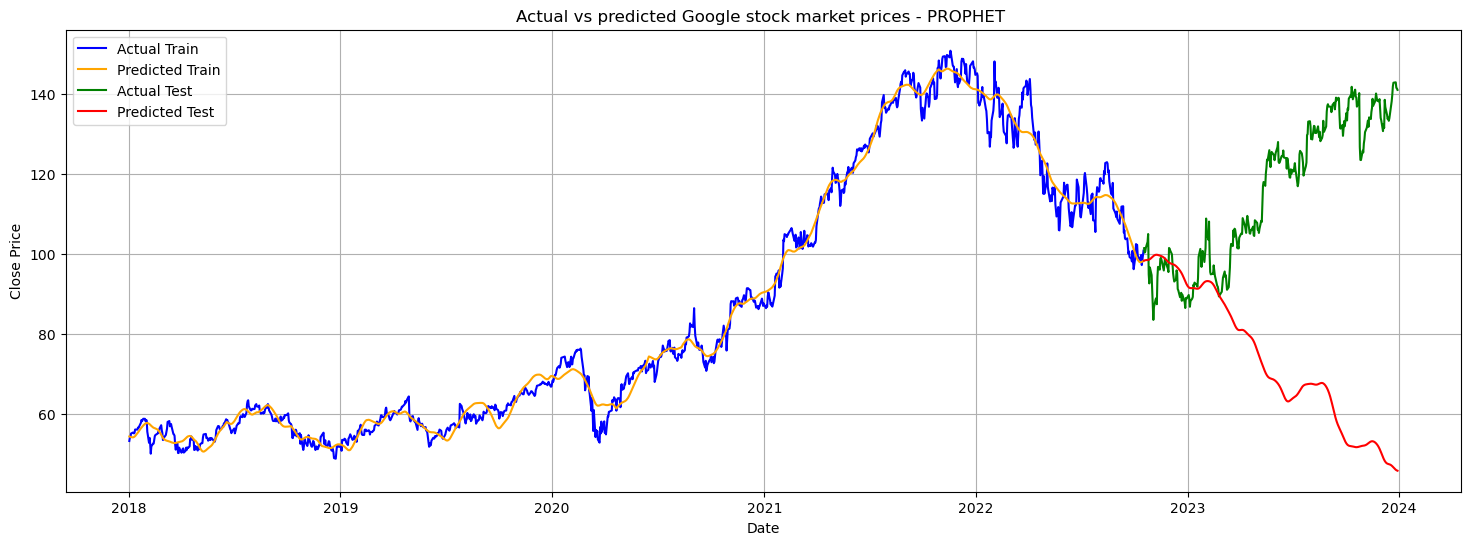

11:23:33 - cmdstanpy - INFO - Chain [1] start processing
11:23:34 - cmdstanpy - INFO - Chain [1] done processing


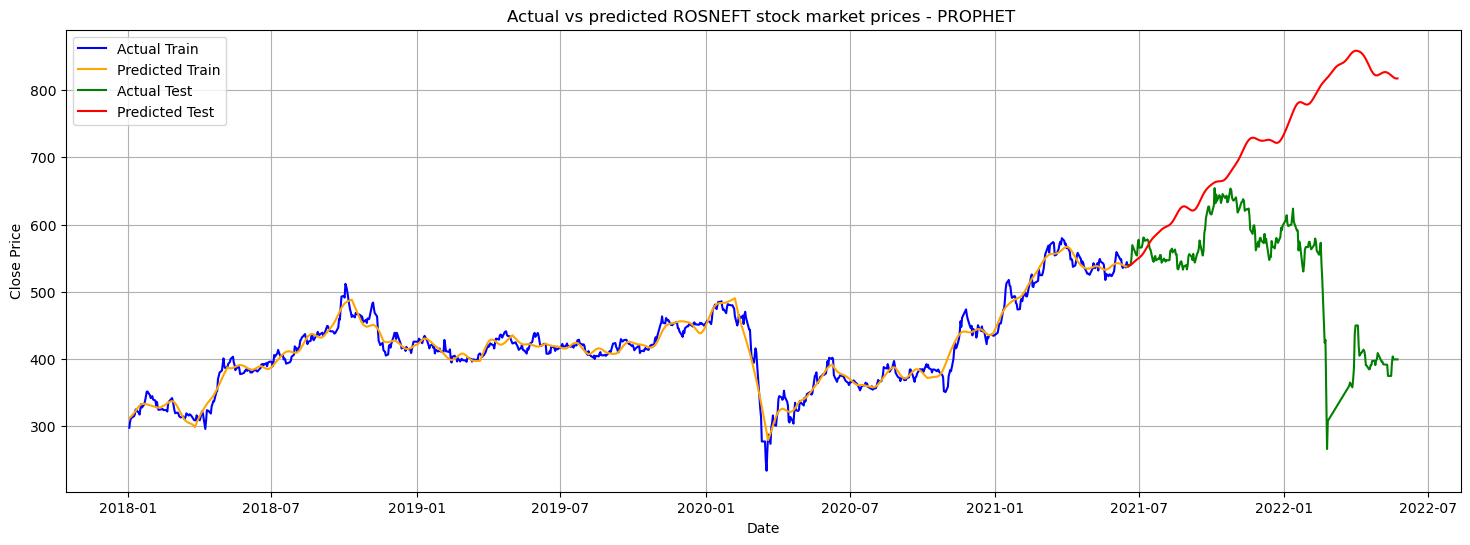

11:23:34 - cmdstanpy - INFO - Chain [1] start processing
11:23:35 - cmdstanpy - INFO - Chain [1] done processing


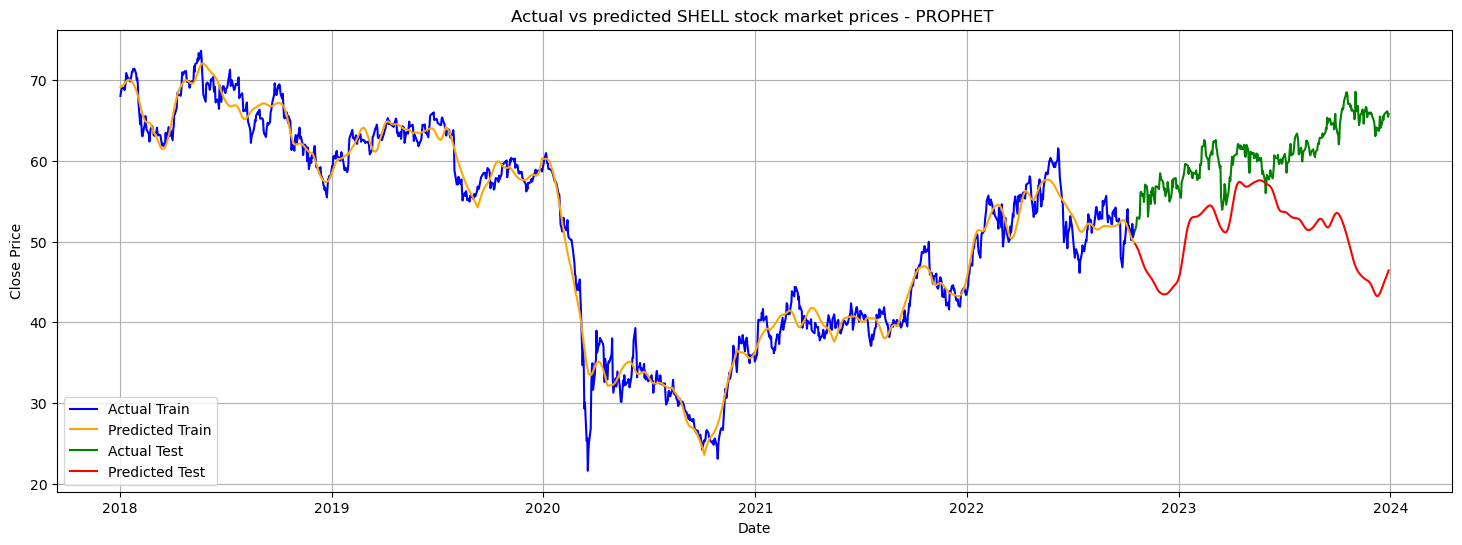

In [20]:
for file in pkl_files:
    company_name = file[:-7]
    
    prophet_metrics = prophet_model(file, 0.8)
    prophet_metrics = [company_name, 'PROPHET'] + prophet_metrics
    
    all_metrics.append(prophet_metrics)

## Evaluation

Let us now observe the final results and evaluation metrics given by our tested models:

In [21]:
columns = ['Company', 'Model', 'MAE', 'MAPE', 'RMSE', 'Training_time']

df_all_metrics = pd.DataFrame(all_metrics, columns=columns)

df_all_metrics.set_index(['Company', 'Model'], inplace=True)

In [23]:
df_all_metrics

MAE        MAPE        RMSE  Training_time
Company    Model                                                     
Alibaba    LSTM      11.069003   12.263301   15.022452      83.284258
BNPParibas LSTM       4.489413   13.881668    5.074188      88.704041
Google     LSTM      34.337434   26.914964   38.620671      79.328227
ROSNEFT    LSTM     114.886507   20.139098  132.038403      53.108337
SHELL      LSTM      10.224265   16.334501   10.659568      82.276858
Alibaba    ARIMA     12.724367   13.606417   15.843760       0.195274
BNPParibas ARIMA      8.288144   26.364289    8.679870       0.265139
Google     ARIMA     18.919701   15.192441   23.085878       0.157860
ROSNEFT    ARIMA     64.801035   13.513756   82.475474       0.109774
SHELL      ARIMA      9.293301   15.005175    9.982132       0.268873
Alibaba    PROPHET   90.734086  104.298664   93.038018       1.484017
BNPParibas PROPHET   19.773632   63.578232   20.294680       1.061626
Google     PROPHET   50.907372   41.389943   58.202986       0.956702
ROSNEFT    PROPHET  238.393972   48.870004  263.863182       1.019539
SHELL      PROPHET    8.829471   14.000087   11.212083       1.226049

In [24]:
df_all_metrics.to_csv('Batch_metrics.csv')